# Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


# Libraries

In [ ]:
!pip install mtcnn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 15.5 MB/s eta 0:00:00


In [ ]:
!pip install hyperopt==0.2.7

In [ ]:
!pip install hyperas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.4/123.4 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.5/93.5 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 13.3 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
import seaborn as sns
import keras
from keras import models
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.optimizers import RMSprop,Adam
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.models import model_from_json
from tensorflow.keras import layers
from PIL import Image
from sklearn.model_selection import train_test_split

from mtcnn import MTCNN

from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

from tensorflow.keras.callbacks import EarlyStopping
from keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications import ResNet152V2

from hyperopt import Trials, STATUS_OK, tpe
from hyperas import optim
from hyperas.distributions import choice, uniform

import tensorflow as tf
tf.config.run_functions_eagerly(True)

from PIL import Image

# Paths

In [ ]:
DATASETS_PATH = "/content/drive/MyDrive/TPP/TPP - sisop?/Datasets/"
NOTEBOOKS_PATH = "/drive/MyDrive/TPP/TPP - sisop?/Notebooks/"
MODELS_PATH = "/content/drive/MyDrive/TPP/TPP - sisop?/Modelos/"
FER2013_PATH = "FER2013/"
EXPW_PATH = "ExpW/ExpW_v1.csv"
EXPW_IMAGES_PATH = "ExpW/images/"
EMO_REACT_PATH = "EmoReact/Frames/"
EXAMPLES_PATH = "Examples/"

# Functions

In [ ]:
def get_emotion(argument):
    labels = {0:'Angry', 1:'Disgust', 2:'Fear', 3:'Happy', 4:'Sad' , 5:'Surprise', 6:'Neutral'}
    return(labels.get(argument, "Invalid emotion"))

In [ ]:
def prepare_data(data):
    """ Prepare data for modeling
        input: dataframe with labels and pixel data
        output: image and label array """

    image_array = np.zeros(shape=(len(data), 48, 48))
    image_label = np.array(list(map(int, data['emotion'])))

    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, 'pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48))
        image_array[i] = image

    return image_array, image_label

In [ ]:
def asserted_prediction(original_row, image_to_predict, model):
    to_predict = np.reshape(image_to_predict.flatten(), (1,48,48,1))
    res = model.predict(to_predict)
    result_num = np.argmax(res)

    return original_row['emotion'] == result_num

In [ ]:
def plot_loss_function(history):
    loss = history.history['loss']
    loss_val = history.history['val_loss']
    epochs = range(1, len(loss)+1)
    plt.plot(epochs, loss, 'bo', label='loss_train')
    plt.plot(epochs, loss_val, 'b', label='loss_val')
    plt.title('value of the loss function')
    plt.xlabel('epochs')
    plt.ylabel('value of the loss function')
    plt.legend()
    plt.grid()
    plt.show()

In [ ]:
def plot_accuracy(history):
    acc = history.history['accuracy']
    acc_val = history.history['val_accuracy']
    loss = history.history['loss']
    epochs = range(1, len(loss)+1)
    plt.plot(epochs, acc, 'bo', label='accuracy_train')
    plt.plot(epochs, acc_val, 'b', label='accuracy_val')
    plt.title('accuracy')
    plt.xlabel('epochs')
    plt.ylabel('value of accuracy')
    plt.legend()
    plt.grid()
    plt.show()

In [ ]:
def get_best_score(history):
    best_score = max(history.history['val_accuracy'])
    print(best_score)

In [ ]:
def export_model(model, name):
    json_string = model.to_json()
    model.save_weights(MODELS_PATH + name +'.h5')
    open(MODELS_PATH + name + '.json', 'w').write(json_string)

In [ ]:
def detect_and_process_face(path):
    pixels = plt.imread(path)

    detector = MTCNN()
    faces = detector.detect_faces(pixels)

    x, y, w, h = faces[0]['box']

    original_image = Image.open(path)
    face = original_image.crop((x, y, x+w, y+h))
    face = face.resize((48, 48))
    face = face.convert('L')

    face_pixels = image.img_to_array(face)
    face_pixels = face_pixels/255

    face_pixels = np.reshape(face_pixels.flatten(), (1,48,48,1))

    return face, face_pixels

In [ ]:
def mult_imgs(set_name):
    """
    Convert one channel images to 3 channels
    """
    set_new = []
    for img in set_name:
        img = img[:,:,0]
        new_img = np.stack((img,)*3, axis=-1)
        #new_img = np.stack((img,) * 3), axis=1)
        set_new.append(new_img)
    return np.array(set_new)

In [ ]:
def print_image(path):
  im = Image.open(path)
  plt.imshow(im)
  plt.show()

# Dataset

In [ ]:
df = pd.read_csv(DATASETS_PATH + 'concatenated.csv')
# df = pd.read_csv(DATASETS_PATH + 'expw.csv')

In [ ]:
df.head()

,Unnamed: 0,emotion,pixels
0,0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,2,231 212 156 164 174 138 161 173 182 200 106 38...
3,3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95688 entries, 0 to 95687
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  95688 non-null  int64 
 1   emotion     95688 non-null  int64 
 2   pixels      95688 non-null  object
dtypes: int64(2), object(1)
memory usage: 2.2+ MB


## Splitting data

In [ ]:
train, test = train_test_split(df, test_size=0.2, random_state=13, stratify=df["emotion"])

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 76550 entries, 75528 to 18222
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  76550 non-null  int64 
 1   emotion     76550 non-null  int64 
 2   pixels      76550 non-null  object
dtypes: int64(2), object(1)
memory usage: 2.3+ MB


In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19138 entries, 8742 to 17215
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  19138 non-null  int64 
 1   emotion     19138 non-null  int64 
 2   pixels      19138 non-null  object
dtypes: int64(2), object(1)
memory usage: 598.1+ KB


In [ ]:
train_image_array, train_image_label = prepare_data(train)
val_image_array, val_image_label = prepare_data(test)

train_images = train_image_array.reshape((train_image_array.shape[0], 48, 48, 1))
train_images = train_images.astype('float32')/255

val_images = val_image_array.reshape((val_image_array.shape[0], 48, 48, 1))
val_images = val_images.astype('float32')/255


train_labels = to_categorical(train_image_label)
val_labels = to_categorical(val_image_label)

## Split in 3

In [ ]:
train_in_3, validate_in_3, test_in_3 = np.split(df.sample(frac=1), [int(.6*len(df)), int(.8*len(df))])

In [ ]:
train_in_3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57412 entries, 21059 to 39593
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  57412 non-null  int64 
 1   emotion     57412 non-null  int64 
 2   pixels      57412 non-null  object
dtypes: int64(2), object(1)
memory usage: 1.8+ MB


In [ ]:
validate_in_3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19138 entries, 18688 to 41557
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  19138 non-null  int64 
 1   emotion     19138 non-null  int64 
 2   pixels      19138 non-null  object
dtypes: int64(2), object(1)
memory usage: 598.1+ KB


In [ ]:
test_in_3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19138 entries, 1718 to 70579
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  19138 non-null  int64 
 1   emotion     19138 non-null  int64 
 2   pixels      19138 non-null  object
dtypes: int64(2), object(1)
memory usage: 598.1+ KB


In [ ]:
train_image_array_in_3, train_image_label_in_3 = prepare_data(train_in_3)
val_image_array_in_3, val_image_label_in_3 = prepare_data(validate_in_3)
test_image_array_in_3, test_image_label_in_3 = prepare_data(test_in_3)

train_images_in_3 = train_image_array_in_3.reshape((train_image_array_in_3.shape[0], 48, 48, 1))
train_images_in_3 = train_images_in_3.astype('float32')/255

val_images_in_3 = val_image_array_in_3.reshape((val_image_array_in_3.shape[0], 48, 48, 1))
val_images_in_3 = val_images_in_3.astype('float32')/255

test_images_in_3 = test_image_array_in_3.reshape((test_image_array_in_3.shape[0], 48, 48, 1))
test_images_in_3 = test_images_in_3.astype('float32')/255


train_labels_in_3 = to_categorical(train_image_label_in_3)
val_labels_in_3 = to_categorical(val_image_label_in_3)
test_labels_in_3 = to_categorical(test_image_label_in_3)

## Data Augmentation

In [ ]:
# Acá estamos usando ImageDataGenerator para hacer Image Augmentation.
# Genera batchs con la data cambiada que van a ser pasados al modelo durante el entrenamiento.
# Los cambios son aplicados de manera aleatoria.

train_datagen = ImageDataGenerator(
        zoom_range=0.2,          # randomly zoom into images
        rotation_range=40,       # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.2,   # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,    # randomly flip images
        vertical_flip=False)     # randomly flip images

train_generator = train_datagen.flow(train_images, train_labels)

In [ ]:
step_size_train = train_generator.n//train_generator.batch_size

# Models

## Model 1 - Basic

In [ ]:
#Sequential significa que vamos a hacer un modelo con varias capas
model1 = Sequential()
#Kernel se le dice al filtro. Así que kernel_size es el tamaño del filtro
#El input shape sólo se necesita en la primera capa
model1.add(Conv2D(filters=32, kernel_size=(3,3), activation="relu", input_shape=(48,48,1)))
model1.add(Conv2D(64, (3,3), activation="relu"))
#Reducción de dimensiones
model1.add(MaxPooling2D(pool_size=(2,2)))
#Preparamos la data para una fully connected layer
model1.add(Flatten())
#Fully connected layers
model1.add(Dense(128, activation="relu"))
#Especificamos cuántas clases va a haber (7 en este caso)
#Softmax nos da un output probabilístico
model1.add(Dense(7, activation="softmax"))

In [ ]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 44, 44, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2  (None, 22, 22, 64)        0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 30976)             0         
                                                                 
 dense (Dense)               (None, 128)               3965056   
                                                                 
 dense_1 (Dense)             (None, 7)                 903       
                                                        

In [ ]:
model1.compile(loss="categorical_crossentropy", optimizer="Adam", metrics=["accuracy"])

In [ ]:
%time

history1 = model1.fit(train_images, train_labels,
                    validation_data=(val_images, val_labels),
                    epochs=25)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.15 µs
Epoch 1/25
2617/2617 [==============================] - 25s 8ms/step - loss: 1.4592 - accuracy: 0.4596 - val_loss: 1.3646 - val_accuracy: 0.4990
Epoch 2/25
2617/2617 [==============================] - 21s 8ms/step - loss: 1.2956 - accuracy: 0.5300 - val_loss: 1.3436 - val_accuracy: 0.5178
Epoch 3/25
2617/2617 [==============================] - 19s 7ms/step - loss: 1.1886 - accuracy: 0.5688 - val_loss: 1.3278 - val_accuracy: 0.5216
Epoch 4/25
2617/2617 [==============================] - 20s 8ms/step - loss: 1.0631 - accuracy: 0.6182 - val_loss: 1.3618 - val_accuracy: 0.5158
Epoch 5/25
2617/2617 [==============================] - 21s 8ms/step - loss: 0.9210 - accuracy: 0.6703 - val_loss: 1.5065 - val_accuracy: 0.5143
Epoch 6/25
2617/2617 [==============================] - 19s 7ms/step - loss: 0.7674 - accuracy: 0.7254 - val_loss: 1.6525 - val_accuracy: 0.4929
Epoch 7/25
2617/2617 [==============================] - 20s 8ms/st

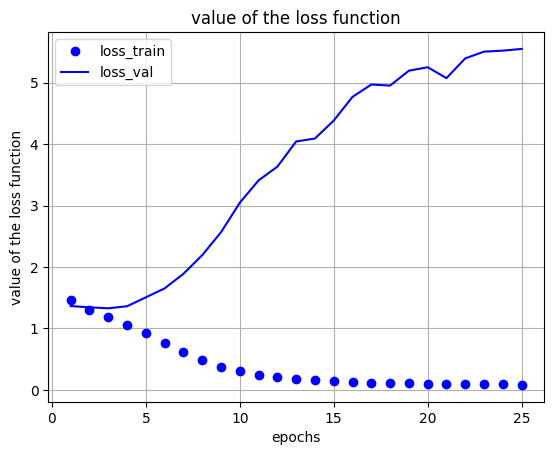

In [ ]:
plot_loss_function(history1)

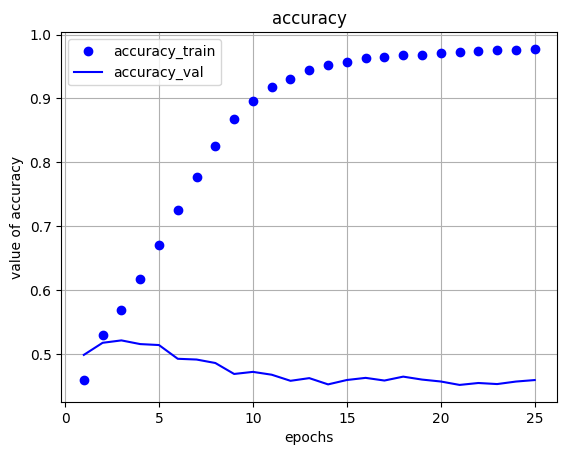

In [ ]:
plot_accuracy(history1)

In [ ]:
export_model(model1, "model1")

## Model 2 - More Layers

In [ ]:
#Sequential significa que vamos a hacer un modelo con varias capas
model2 = Sequential()
#Kernel se le dice al filtro. Así que kernel_size es el tamaño del filtro
#El input shape sólo se necesita en la primera capa
model2.add(Conv2D(filters=32, kernel_size=(3,3), activation="relu", input_shape=(48,48,1)))
model2.add(Conv2D(64, (3,3), activation="relu"))

#Reducción de dimensiones
model2.add(MaxPooling2D(pool_size=(2,2)))

model2.add(Conv2D(80, (3, 3), activation='relu'))
model2.add(Conv2D(90, (3, 3), activation='relu'))

model2.add(MaxPooling2D(pool_size=(2,2)))

#Preparamos la data para una fully connected layer
model2.add(Flatten())
#Fully connected layers
model2.add(Dense(128, activation="relu"))
#Especificamos cuántas clases va a haber (7 en este caso)
#Softmax nos da un output probabilístico
model2.add(Dense(7, activation="softmax"))

In [ ]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 46, 46, 32)        320       
                                                                 
 conv2d_3 (Conv2D)           (None, 44, 44, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 22, 22, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 20, 20, 80)        46160     
                                                                 
 conv2d_5 (Conv2D)           (None, 18, 18, 90)        64890     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 9, 9, 90)          0         
 g2D)                                                 

In [ ]:
model2.compile(loss="categorical_crossentropy", optimizer="Adam", metrics=["accuracy"])

In [ ]:
%time

history2 = model2.fit(train_images, train_labels,
                    validation_data=(val_images, val_labels),
                    epochs=25)

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 8.58 µs
Epoch 1/25
2617/2617 [==============================] - 26s 9ms/step - loss: 1.4494 - accuracy: 0.4593 - val_loss: 1.3229 - val_accuracy: 0.5200
Epoch 2/25
2617/2617 [==============================] - 23s 9ms/step - loss: 1.2540 - accuracy: 0.5459 - val_loss: 1.2573 - val_accuracy: 0.5500
Epoch 3/25
2617/2617 [==============================] - 23s 9ms/step - loss: 1.1718 - accuracy: 0.5783 - val_loss: 1.2607 - val_accuracy: 0.5515
Epoch 4/25
2617/2617 [==============================] - 24s 9ms/step - loss: 1.0959 - accuracy: 0.6056 - val_loss: 1.2419 - val_accuracy: 0.5590
Epoch 5/25
2617/2617 [==============================] - 23s 9ms/step - loss: 1.0122 - accuracy: 0.6368 - val_loss: 1.2694 - val_accuracy: 0.5551
Epoch 6/25
2617/2617 [==============================] - 25s 9ms/step - loss: 0.9224 - accuracy: 0.6698 - val_loss: 1.3400 - val_accuracy: 0.5462
Epoch 7/25
2617/2617 [==============================] - 24s 9m

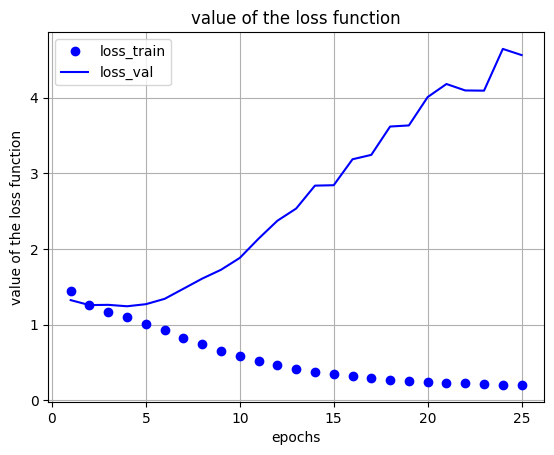

In [ ]:
plot_loss_function(history2)

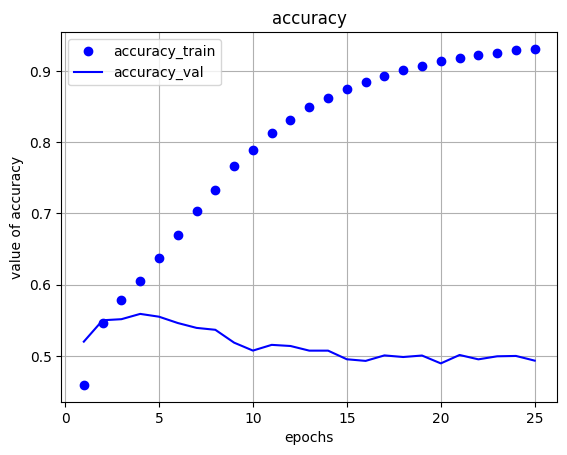

In [ ]:
plot_accuracy(history2)

In [ ]:
export_model(model2, "model2")

## Model 3 - Using Dropout

In [ ]:
#Sequential significa que vamos a hacer un modelo con varias capas
model3 = Sequential()
#Kernel se le dice al filtro. Así que kernel_size es el tamaño del filtro
#El input shape sólo se necesita en la primera capa
model3.add(Conv2D(filters=32, kernel_size=(3,3), activation="relu", input_shape=(48,48,1)))
model3.add(Conv2D(64, (3,3), activation="relu"))

#Reducción de dimensiones
model3.add(MaxPooling2D(pool_size=(2,2)))
model3.add(Dropout(0.2))

model3.add(Conv2D(80, (3, 3), activation='relu'))
model3.add(Conv2D(90, (3, 3), activation='relu'))

model3.add(MaxPooling2D(pool_size=(2,2)))
model3.add(Dropout(0.2))
#Preparamos la data para una fully connected layer
model3.add(Flatten())
#Fully connected layers
model3.add(Dense(128, activation="relu"))
#Especificamos cuántas clases va a haber (7 en este caso)
#Softmax nos da un output probabilístico
model3.add(Dense(7, activation="softmax"))

In [ ]:
model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 46, 46, 32)        320       
                                                                 
 conv2d_7 (Conv2D)           (None, 44, 44, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 22, 22, 64)        0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 22, 22, 64)        0         
                                                                 
 conv2d_8 (Conv2D)           (None, 20, 20, 80)        46160     
                                                                 
 conv2d_9 (Conv2D)           (None, 18, 18, 90)        64890     
                                                      

In [ ]:
model3.compile(loss="categorical_crossentropy", optimizer="Adam", metrics=["accuracy"])

In [ ]:
%time

history3 = model3.fit(train_images, train_labels,
                    validation_data=(val_images, val_labels),
                    epochs=25
                      )

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 26 µs
Epoch 1/25
2617/2617 [==============================] - 29s 11ms/step - loss: 0.9738 - accuracy: 0.6490 - val_loss: 1.3097 - val_accuracy: 0.5543
Epoch 2/25
2617/2617 [==============================] - 29s 11ms/step - loss: 0.9280 - accuracy: 0.6653 - val_loss: 1.3289 - val_accuracy: 0.5551
Epoch 3/25
2617/2617 [==============================] - 28s 11ms/step - loss: 0.8894 - accuracy: 0.6783 - val_loss: 1.3754 - val_accuracy: 0.5547
Epoch 4/25
2617/2617 [==============================] - 28s 11ms/step - loss: 0.8589 - accuracy: 0.6876 - val_loss: 1.4124 - val_accuracy: 0.5546
Epoch 5/25
2617/2617 [==============================] - 28s 11ms/step - loss: 0.8205 - accuracy: 0.7023 - val_loss: 1.4346 - val_accuracy: 0.5484
Epoch 6/25
2617/2617 [==============================] - 28s 11ms/step - loss: 0.7956 - accuracy: 0.7114 - val_loss: 1.4456 - val_accuracy: 0.5450
Epoch 7/25
2617/2617 [==============================] - 28s 11

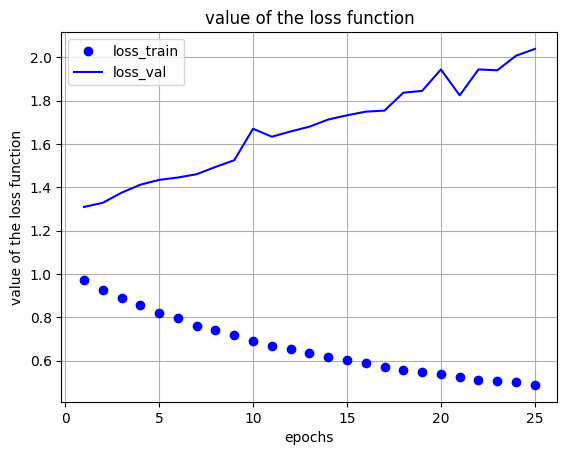

In [ ]:
plot_loss_function(history3)

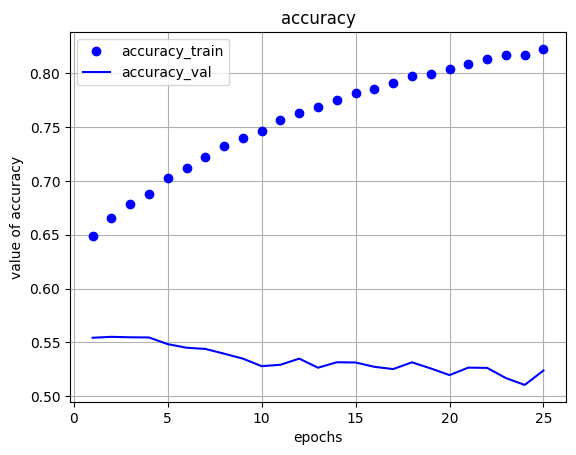

In [ ]:
plot_accuracy(history3)

In [ ]:
export_model(model3, "model3")

## Model 4 - PoleEmploi (Franchutes)

In [ ]:
model4 = Sequential()

model4.add(Conv2D(20, (3, 3), padding='same', activation='relu', input_shape=(48,48,1)))
model4.add(Conv2D(30, (3, 3), padding='same', activation='relu'))
model4.add(MaxPooling2D(pool_size=(2, 2)))
model4.add(BatchNormalization())
model4.add(Dropout(0.2))

model4.add(Conv2D(40, (3, 3), padding='same', activation='relu'))
model4.add(Conv2D(50, (3, 3), padding='same', activation='relu'))
model4.add(MaxPooling2D(pool_size=(2, 2)))
model4.add(BatchNormalization())
model4.add(Dropout(0.2))

model4.add(Conv2D(60, (3, 3), padding='same', activation='relu'))
model4.add(Conv2D(70, (3, 3), padding='same', activation='relu'))
model4.add(MaxPooling2D(pool_size=(2, 2)))
model4.add(Dropout(0.2))

model4.add(Conv2D(80, (3, 3), padding='same', activation='relu'))
model4.add(Conv2D(90, (3, 3), padding='same', activation='relu'))

#Flattening
model4.add(Flatten())

#Adding fully connected layer
model4.add(Dense(1000, activation='relu'))
model4.add(Dense(512, activation='relu'))

#Adding Output Layer
model4.add(Dense(7, activation='softmax'))

In [ ]:
model4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 48, 48, 20)        200       
                                                                 
 conv2d_11 (Conv2D)          (None, 48, 48, 30)        5430      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 24, 24, 30)        0         
 g2D)                                                            
                                                                 
 batch_normalization (Batch  (None, 24, 24, 30)        120       
 Normalization)                                                  
                                                                 
 dropout_2 (Dropout)         (None, 24, 24, 30)        0         
                                                                 
 conv2d_12 (Conv2D)          (None, 24, 24, 40)       

In [ ]:
model4.compile(loss="categorical_crossentropy", optimizer="Adam", metrics=["accuracy"])

In [ ]:
%time

history4 = model4.fit(train_images, train_labels,
                    validation_data=(val_images, val_labels),
                    epochs=100
                      )

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.48 µs
Epoch 1/100
2617/2617 [==============================] - 35s 11ms/step - loss: 1.4900 - accuracy: 0.4490 - val_loss: 1.5826 - val_accuracy: 0.4078
Epoch 2/100
2617/2617 [==============================] - 28s 11ms/step - loss: 1.3409 - accuracy: 0.5131 - val_loss: 1.3089 - val_accuracy: 0.5258
Epoch 3/100
2617/2617 [==============================] - 29s 11ms/step - loss: 1.2898 - accuracy: 0.5339 - val_loss: 1.2568 - val_accuracy: 0.5445
Epoch 4/100
2617/2617 [==============================] - 29s 11ms/step - loss: 1.2565 - accuracy: 0.5462 - val_loss: 1.2381 - val_accuracy: 0.5537
Epoch 5/100
2617/2617 [==============================] - 28s 11ms/step - loss: 1.2312 - accuracy: 0.5565 - val_loss: 1.2396 - val_accuracy: 0.5504
Epoch 6/100
2617/2617 [==============================] - 29s 11ms/step - loss: 1.2106 - accuracy: 0.5632 - val_loss: 1.2152 - val_accuracy: 0.5667
Epoch 7/100
2617/2617 [==============================]

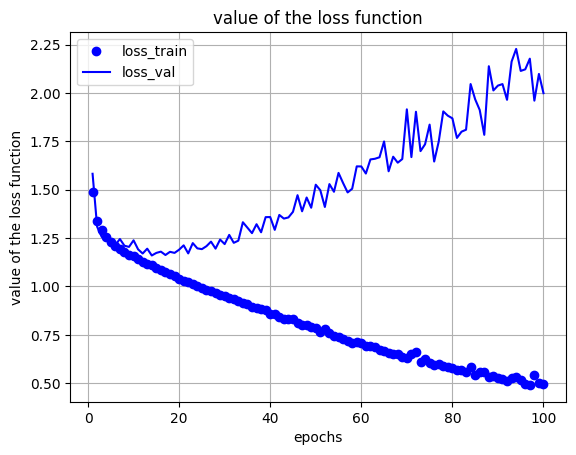

In [ ]:
plot_loss_function(history4)

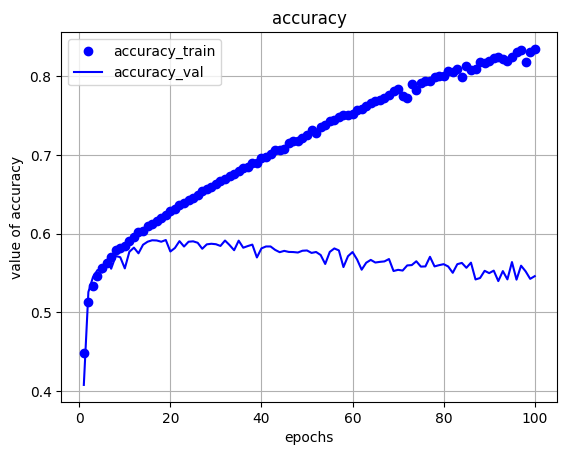

In [ ]:
plot_accuracy(history4)

In [ ]:
export_model(model4, "model4")

## Model 5 - Challenge Kaggle

In [ ]:
model5 = Sequential([
    ##La primera capa convolucional tiene 32 filtros de tamaño (3,3), utiliza la función de activación ReLU,
    ##tiene un relleno ('padding') de 'same' para mantener el tamaño de la imagen y espera una entrada de forma (48, 48, 1).
    Conv2D(32, (3,3), activation = 'relu', padding = 'same', input_shape = (48,48,1)),
    Conv2D(32, (3,3), activation = 'relu', padding = 'same'),

    ##Ambas capas están seguidas por una capa de MaxPooling para reducir la dimensionalidad de la salida.
    MaxPooling2D(2,2),
    ##La capa Dropout se utiliza para regularizar la red y evitar el sobreajuste.
    Dropout(0.25),
    ##La capa BatchNormalization normaliza las activaciones de la capa anterior para mejorar la estabilidad y el entrenamiento.
    BatchNormalization(),

    ##Se repite un patrón similar con dos capas convolucionales adicionales, cada una con 64 filtros y
    ##seguidas por MaxPooling, Dropout y BatchNormalization.
    Conv2D(64, (3,3), activation = 'relu', padding = 'same'),
    Conv2D(64, (3,3), activation = 'relu', padding = 'same'),
    MaxPooling2D(2,2),
    Dropout(0.25),
    BatchNormalization(),

    ##Se repite el patrón nuevamente con dos capas convolucionales más, cada una con 128 filtros.
    Conv2D(128, (3,3), activation = 'relu', padding = 'same'),
    Conv2D(128, (3,3), activation = 'relu', padding = 'same'),
    MaxPooling2D(2,2),
    Dropout(0.25),
    BatchNormalization(),

    ##La capa Flatten se utiliza para transformar la salida
    ##3D de las capas convolucionales en un vector 1D antes de pasar a capas densamente conectadas.
    Flatten(),

    ##Se añaden tres capas densamente conectadas (totalmente conectadas) con funciones de activación ReLU y Dropout para regularización.
    ##La última capa densa tiene 7 neuronas (correspondientes a las clases de salida)
    ## y utiliza la función de activación softmax para la clasificación multiclase.
    Dense(64, activation='relu'),
    Dropout(0.25),
    Dense(32, activation='relu'),
    Dropout(0.25),
    BatchNormalization(),
    Dense(7, activation='softmax')
])

model5.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 24, 24, 32)        0         
                                                                 
 batch_normalization (Batch  (None, 24, 24, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 64)        1

In [ ]:
model5.compile(optimizer="Adam", loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
%time

history5 = model5.fit(train_images, train_labels,
                    validation_data=(val_images, val_labels),
                    epochs=100)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.63 µs
Epoch 1/100
1636/1636 [==============================] - 34s 14ms/step - loss: 1.6365 - accuracy: 0.3782 - val_loss: 1.4319 - val_accuracy: 0.4723
Epoch 2/100
1636/1636 [==============================] - 20s 12ms/step - loss: 1.3985 - accuracy: 0.4978 - val_loss: 1.3569 - val_accuracy: 0.5197
Epoch 3/100
1636/1636 [==============================] - 19s 12ms/step - loss: 1.3336 - accuracy: 0.5302 - val_loss: 1.2630 - val_accuracy: 0.5464
Epoch 4/100
1636/1636 [==============================] - 20s 13ms/step - loss: 1.2974 - accuracy: 0.5459 - val_loss: 1.2449 - val_accuracy: 0.5550
Epoch 5/100
1636/1636 [==============================] - 19s 12ms/step - loss: 1.2724 - accuracy: 0.5549 - val_loss: 1.2322 - val_accuracy: 0.5634
Epoch 6/100
1636/1636 [==============================] - 20s 12ms/step - loss: 1.2486 - accuracy: 0.5671 - val_loss: 1.2347 - val_accuracy: 0.5615
Epoch 7/100
1636/1636 [==============================]

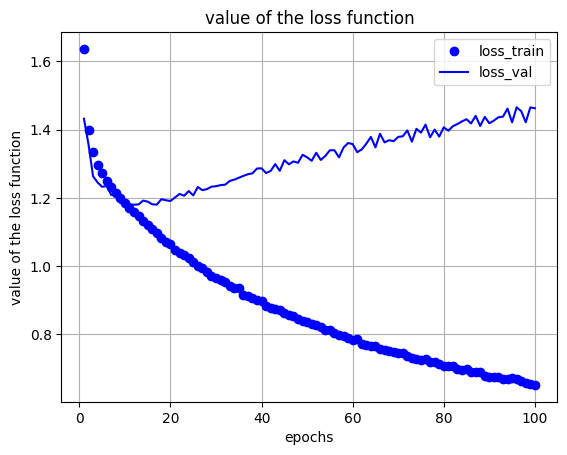

In [ ]:
plot_loss_function(history5)

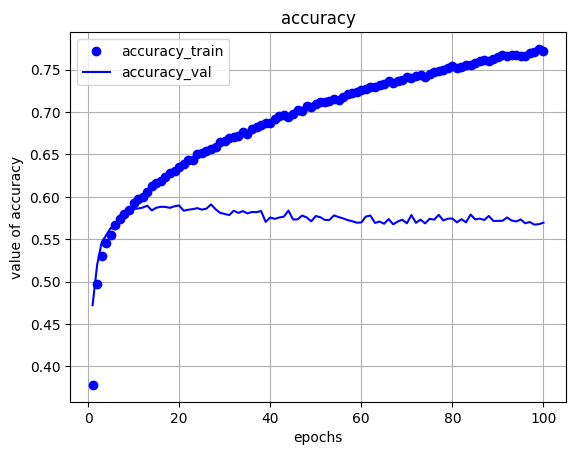

In [ ]:
plot_accuracy(history5)

In [ ]:
export_model(model5, "model5_expw")

## Model 6 - Model 5 using data augmentation

In [ ]:
%time

history6 = model5.fit(
    train_generator,
    steps_per_epoch=step_size_train,
    epochs = 100,
    validation_data=(val_images, val_labels)
)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 8.82 µs
Epoch 1/100
2392/2392 [==============================] - 65s 23ms/step - loss: 1.7501 - accuracy: 0.3037 - val_loss: 1.6383 - val_accuracy: 0.3511
Epoch 2/100
2392/2392 [==============================] - 55s 23ms/step - loss: 1.6411 - accuracy: 0.3526 - val_loss: 1.6785 - val_accuracy: 0.3365
Epoch 3/100
2392/2392 [==============================] - 52s 22ms/step - loss: 1.5640 - accuracy: 0.4100 - val_loss: 1.4629 - val_accuracy: 0.4685
Epoch 4/100
2392/2392 [==============================] - 54s 23ms/step - loss: 1.4908 - accuracy: 0.4511 - val_loss: 1.3383 - val_accuracy: 0.5163
Epoch 5/100
2392/2392 [==============================] - 52s 22ms/step - loss: 1.4560 - accuracy: 0.4681 - val_loss: 1.3040 - val_accuracy: 0.5292
Epoch 6/100
2392/2392 [==============================] - 53s 22ms/step - loss: 1.4292 - accuracy: 0.4807 - val_loss: 1.3551 - val_accuracy: 0.5218
Epoch 7/100
2392/2392 [==============================]

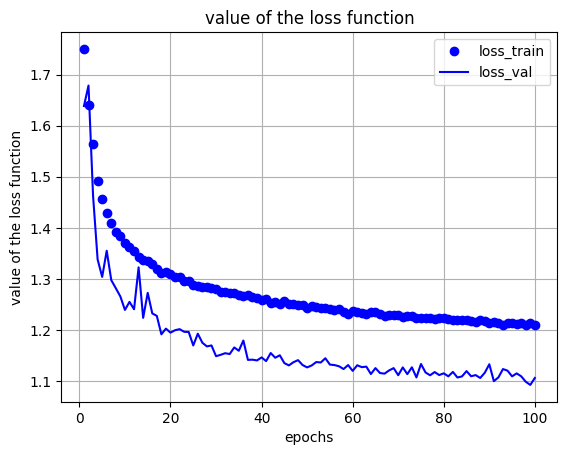

In [ ]:
plot_loss_function(history6)

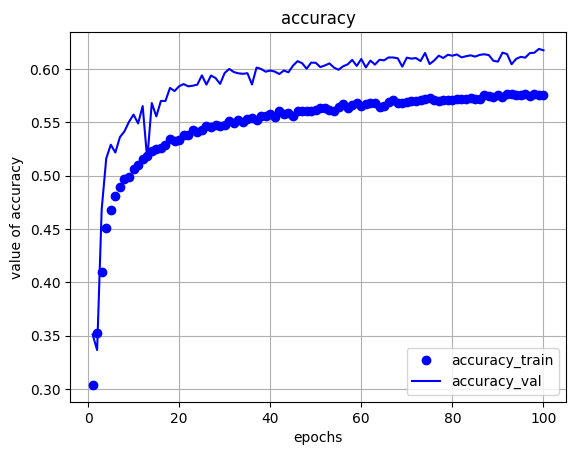

In [ ]:
plot_accuracy(history6)

In [ ]:
export_model(model5, "model6")

## Model 7 - Model 5 changing learning rate

In [ ]:
model7 = Sequential([
    ##La primera capa convolucional tiene 32 filtros de tamaño (3,3), utiliza la función de activación ReLU,
    ##tiene un relleno ('padding') de 'same' para mantener el tamaño de la imagen y espera una entrada de forma (48, 48, 1).
    Conv2D(32, (3,3), activation = 'relu', padding = 'same', input_shape = (48,48,1)),
    Conv2D(32, (3,3), activation = 'relu', padding = 'same'),

    ##Ambas capas están seguidas por una capa de MaxPooling para reducir la dimensionalidad de la salida.
    MaxPooling2D(2,2),
    ##La capa Dropout se utiliza para regularizar la red y evitar el sobreajuste.
    Dropout(0.25),
    ##La capa BatchNormalization normaliza las activaciones de la capa anterior para mejorar la estabilidad y el entrenamiento.
    BatchNormalization(),

    ##Se repite un patrón similar con dos capas convolucionales adicionales, cada una con 64 filtros y
    ##seguidas por MaxPooling, Dropout y BatchNormalization.
    Conv2D(64, (3,3), activation = 'relu', padding = 'same'),
    Conv2D(64, (3,3), activation = 'relu', padding = 'same'),
    MaxPooling2D(2,2),
    Dropout(0.25),
    BatchNormalization(),

    ##Se repite el patrón nuevamente con dos capas convolucionales más, cada una con 128 filtros.
    Conv2D(128, (3,3), activation = 'relu', padding = 'same'),
    Conv2D(128, (3,3), activation = 'relu', padding = 'same'),
    MaxPooling2D(2,2),
    Dropout(0.25),
    BatchNormalization(),

    ##La capa Flatten se utiliza para transformar la salida
    ##3D de las capas convolucionales en un vector 1D antes de pasar a capas densamente conectadas.
    Flatten(),

    ##Se añaden tres capas densamente conectadas (totalmente conectadas) con funciones de activación ReLU y Dropout para regularización.
    ##La última capa densa tiene 7 neuronas (correspondientes a las clases de salida)
    ## y utiliza la función de activación softmax para la clasificación multiclase.
    Dense(64, activation='relu'),
    Dropout(0.25),
    Dense(32, activation='relu'),
    Dropout(0.25),
    BatchNormalization(),
    Dense(7, activation='softmax')
])

model7.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 24, 24, 32)        0         
                                                                 
 batch_normalization (Batch  (None, 24, 24, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 64)        1

In [ ]:
lr_reduce = ReduceLROnPlateau(monitor="val_accuracy", factor=0.1, min_delta=0.001, patience=3, verbose=1)

filepath = MODELS_PATH + "weights_7.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor="val_accuracy", verbose=1, save_best_only=True, mode="max")

In [ ]:
optimizer = keras.optimizers.Adam(learning_rate=0.001)

model7.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
%time

history7 = model7.fit(train_images, train_labels,
                    validation_data=(val_images, val_labels),
                    epochs=100,
                    callbacks=[lr_reduce, checkpoint])

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.11 µs
Epoch 1/100
2393/2393 [==============================] - ETA: 0s - loss: 1.6563 - accuracy: 0.3732
Epoch 1: val_accuracy improved from -inf to 0.48652, saving model to /content/drive/MyDrive/TPP/TPP - sisop?/Modelos/weights_7.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2393/2393 [==============================] - 40s 13ms/step - loss: 1.6563 - accuracy: 0.3732 - val_loss: 1.4267 - val_accuracy: 0.4865 - lr: 0.0010
Epoch 2/100
2390/2393 [============================>.] - ETA: 0s - loss: 1.4056 - accuracy: 0.4904
Epoch 2: val_accuracy improved from 0.48652 to 0.51730, saving model to /content/drive/MyDrive/TPP/TPP - sisop?/Modelos/weights_7.hdf5
2393/2393 [==============================] - 31s 13ms/step - loss: 1.4057 - accuracy: 0.4904 - val_loss: 1.3173 - val_accuracy: 0.5173 - lr: 0.0010
Epoch 3/100
2390/2393 [============================>.] - ETA: 0s - loss: 1.3396 - accuracy: 0.5186
Epoch 3: val_accuracy improved from 0.51730 to 0.54441, saving model to /content/drive/MyDrive/TPP/TPP - sisop?/Modelos/weights_7.hdf5
2393/2393 [==============================] - 34s 14ms/step - loss: 1.3393 - accuracy: 0.5187 - val_loss: 1.2763 - val_accuracy: 0.5444 - lr: 0.0010
Epoch 4/100
2390/2393 [============================>.] - ETA: 0s - loss: 1.2970 - accura

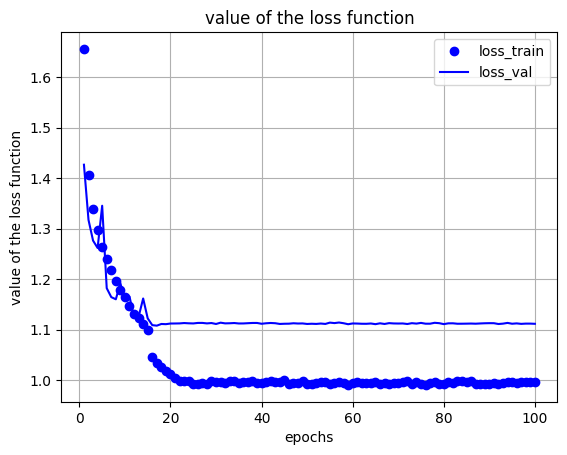

In [ ]:
plot_loss_function(history7)

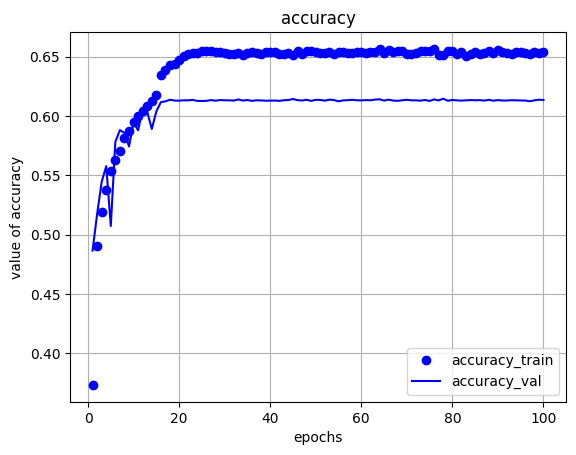

In [ ]:
plot_accuracy(history7)

In [ ]:
export_model(model7, "model7")

## Model 8 - Model 7 using data augmentation

In [ ]:
%time

history8 = model7.fit(
    train_generator,
    steps_per_epoch=step_size_train,
    epochs = 100,
    validation_data=(val_images, val_labels)
)

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 6.44 µs
Epoch 1/100
2392/2392 [==============================] - 65s 23ms/step - loss: 1.7654 - accuracy: 0.2942 - val_loss: 1.6543 - val_accuracy: 0.3383
Epoch 2/100
2392/2392 [==============================] - 53s 22ms/step - loss: 1.6669 - accuracy: 0.3323 - val_loss: 1.7058 - val_accuracy: 0.3395
Epoch 3/100
2392/2392 [==============================] - 52s 22ms/step - loss: 1.6327 - accuracy: 0.3581 - val_loss: 1.5860 - val_accuracy: 0.3919
Epoch 4/100
2392/2392 [==============================] - 54s 22ms/step - loss: 1.5859 - accuracy: 0.3940 - val_loss: 1.4515 - val_accuracy: 0.4626
Epoch 5/100
2392/2392 [==============================] - 70s 29ms/step - loss: 1.5181 - accuracy: 0.4371 - val_loss: 1.3637 - val_accuracy: 0.5036
Epoch 6/100
2392/2392 [==============================] - 52s 22ms/step - loss: 1.4752 - accuracy: 0.4585 - val_loss: 1.3730 - val_accuracy: 0.5113
Epoch 7/100
2392/2392 [===========================

In [ ]:
plot_loss_function(history8)

In [ ]:
plot_accuracy(history8)

## Model 9a - Batch size 64



In [ ]:
model9a = Sequential([
    ##La primera capa convolucional tiene 32 filtros de tamaño (3,3), utiliza la función de activación ReLU,
    ##tiene un relleno ('padding') de 'same' para mantener el tamaño de la imagen y espera una entrada de forma (48, 48, 1).
    Conv2D(32, (3,3), activation = 'relu', padding = 'same', input_shape = (48,48,1)),
    Conv2D(32, (3,3), activation = 'relu', padding = 'same'),

    ##Ambas capas están seguidas por una capa de MaxPooling para reducir la dimensionalidad de la salida.
    MaxPooling2D(2,2),
    ##La capa Dropout se utiliza para regularizar la red y evitar el sobreajuste.
    Dropout(0.25),
    ##La capa BatchNormalization normaliza las activaciones de la capa anterior para mejorar la estabilidad y el entrenamiento.
    BatchNormalization(),

    ##Se repite un patrón similar con dos capas convolucionales adicionales, cada una con 64 filtros y
    ##seguidas por MaxPooling, Dropout y BatchNormalization.
    Conv2D(64, (3,3), activation = 'relu', padding = 'same'),
    Conv2D(64, (3,3), activation = 'relu', padding = 'same'),
    MaxPooling2D(2,2),
    Dropout(0.25),
    BatchNormalization(),

    ##Se repite el patrón nuevamente con dos capas convolucionales más, cada una con 128 filtros.
    Conv2D(128, (3,3), activation = 'relu', padding = 'same'),
    Conv2D(128, (3,3), activation = 'relu', padding = 'same'),
    MaxPooling2D(2,2),
    Dropout(0.25),
    BatchNormalization(),

    ##La capa Flatten se utiliza para transformar la salida
    ##3D de las capas convolucionales en un vector 1D antes de pasar a capas densamente conectadas.
    Flatten(),

    ##Se añaden tres capas densamente conectadas (totalmente conectadas) con funciones de activación ReLU y Dropout para regularización.
    ##La última capa densa tiene 7 neuronas (correspondientes a las clases de salida)
    ## y utiliza la función de activación softmax para la clasificación multiclase.
    Dense(64, activation='relu'),
    Dropout(0.25),
    Dense(32, activation='relu'),
    Dropout(0.25),
    BatchNormalization(),
    Dense(7, activation='softmax')
])

model9a.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 48, 48, 32)        320       
                                                                 
 conv2d_7 (Conv2D)           (None, 48, 48, 32)        9248      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 24, 24, 32)        0         
 g2D)                                                            
                                                                 
 dropout_5 (Dropout)         (None, 24, 24, 32)        0         
                                                                 
 batch_normalization_4 (Bat  (None, 24, 24, 32)        128       
 chNormalization)                                                
                                                                 
 conv2d_8 (Conv2D)           (None, 24, 24, 64)       

In [ ]:
optimizer = keras.optimizers.Adam(learning_rate=0.001)

model9a.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
%time

history9a = model9a.fit(train_images, train_labels,
                    validation_data=(val_images, val_labels),
                    epochs=100,
                    batch_size=64
                    )

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 9.06 µs
Epoch 1/100
1197/1197 [==============================] - 31s 22ms/step - loss: 1.7670 - accuracy: 0.3183 - val_loss: 1.5658 - val_accuracy: 0.4213
Epoch 2/100
1197/1197 [==============================] - 26s 21ms/step - loss: 1.4713 - accuracy: 0.4622 - val_loss: 1.3909 - val_accuracy: 0.4940
Epoch 3/100
1197/1197 [==============================] - 26s 21ms/step - loss: 1.3675 - accuracy: 0.5047 - val_loss: 1.3083 - val_accuracy: 0.5326
Epoch 4/100
1197/1197 [==============================] - 25s 21ms/step - loss: 1.3132 - accuracy: 0.5287 - val_loss: 1.2679 - val_accuracy: 0.5424
Epoch 5/100
1197/1197 [==============================] - 26s 22ms/step - loss: 1.2766 - accuracy: 0.5467 - val_loss: 1.2813 - val_accuracy: 0.5486
Epoch 6/100
1197/1197 [==============================] - 26s 22ms/step - loss: 1.2443 - accuracy: 0.5597 - val_loss: 1.1989 - val_accuracy: 0.5743
Epoch 7/100
1197/1197 [==============================]

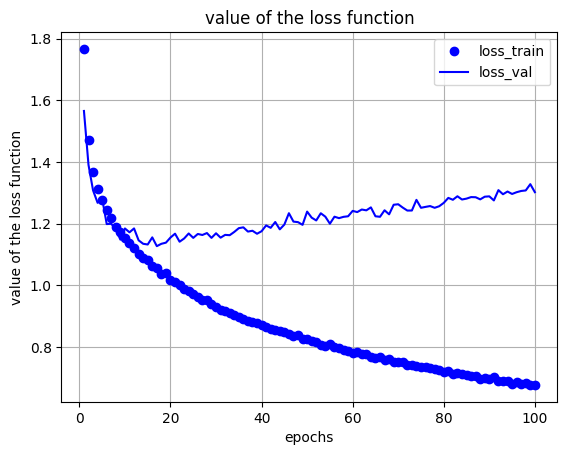

In [ ]:
plot_loss_function(history9a)

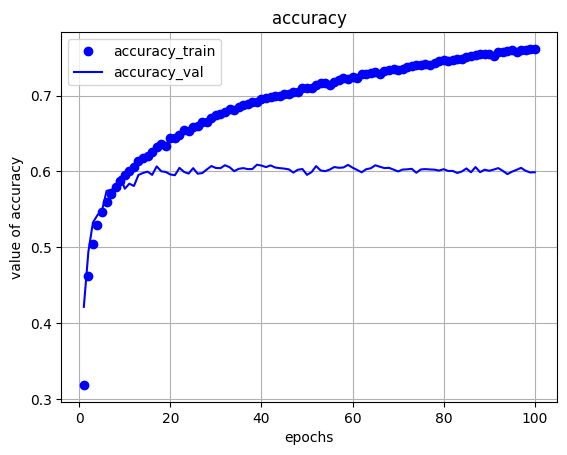

In [ ]:
plot_accuracy(history9a)

## Model 9b - Batch size 128

In [ ]:
model9b = Sequential([
    ##La primera capa convolucional tiene 32 filtros de tamaño (3,3), utiliza la función de activación ReLU,
    ##tiene un relleno ('padding') de 'same' para mantener el tamaño de la imagen y espera una entrada de forma (48, 48, 1).
    Conv2D(32, (3,3), activation = 'relu', padding = 'same', input_shape = (48,48,1)),
    Conv2D(32, (3,3), activation = 'relu', padding = 'same'),

    ##Ambas capas están seguidas por una capa de MaxPooling para reducir la dimensionalidad de la salida.
    MaxPooling2D(2,2),
    ##La capa Dropout se utiliza para regularizar la red y evitar el sobreajuste.
    Dropout(0.25),
    ##La capa BatchNormalization normaliza las activaciones de la capa anterior para mejorar la estabilidad y el entrenamiento.
    BatchNormalization(),

    ##Se repite un patrón similar con dos capas convolucionales adicionales, cada una con 64 filtros y
    ##seguidas por MaxPooling, Dropout y BatchNormalization.
    Conv2D(64, (3,3), activation = 'relu', padding = 'same'),
    Conv2D(64, (3,3), activation = 'relu', padding = 'same'),
    MaxPooling2D(2,2),
    Dropout(0.25),
    BatchNormalization(),

    ##Se repite el patrón nuevamente con dos capas convolucionales más, cada una con 128 filtros.
    Conv2D(128, (3,3), activation = 'relu', padding = 'same'),
    Conv2D(128, (3,3), activation = 'relu', padding = 'same'),
    MaxPooling2D(2,2),
    Dropout(0.25),
    BatchNormalization(),

    ##La capa Flatten se utiliza para transformar la salida
    ##3D de las capas convolucionales en un vector 1D antes de pasar a capas densamente conectadas.
    Flatten(),

    ##Se añaden tres capas densamente conectadas (totalmente conectadas) con funciones de activación ReLU y Dropout para regularización.
    ##La última capa densa tiene 7 neuronas (correspondientes a las clases de salida)
    ## y utiliza la función de activación softmax para la clasificación multiclase.
    Dense(64, activation='relu'),
    Dropout(0.25),
    Dense(32, activation='relu'),
    Dropout(0.25),
    BatchNormalization(),
    Dense(7, activation='softmax')
])

model9b.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 48, 48, 32)        320       
                                                                 
 conv2d_7 (Conv2D)           (None, 48, 48, 32)        9248      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 24, 24, 32)        0         
 g2D)                                                            
                                                                 
 dropout_5 (Dropout)         (None, 24, 24, 32)        0         
                                                                 
 batch_normalization_4 (Bat  (None, 24, 24, 32)        128       
 chNormalization)                                                
                                                                 
 conv2d_8 (Conv2D)           (None, 24, 24, 64)       

In [ ]:
optimizer = keras.optimizers.Adam(learning_rate=0.001)

model9b.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
%time

history9b = model9b.fit(train_images, train_labels,
                    validation_data=(val_images, val_labels),
                    epochs=100,
                    batch_size=128
                    )

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.58 µs
Epoch 1/100
599/599 [==============================] - 32s 35ms/step - loss: 1.7038 - accuracy: 0.3657 - val_loss: 1.5498 - val_accuracy: 0.4177
Epoch 2/100
599/599 [==============================] - 21s 35ms/step - loss: 1.4164 - accuracy: 0.4851 - val_loss: 1.3317 - val_accuracy: 0.5150
Epoch 3/100
599/599 [==============================] - 20s 33ms/step - loss: 1.3332 - accuracy: 0.5205 - val_loss: 1.3373 - val_accuracy: 0.5167
Epoch 4/100
599/599 [==============================] - 21s 34ms/step - loss: 1.2928 - accuracy: 0.5374 - val_loss: 1.2779 - val_accuracy: 0.5404
Epoch 5/100
599/599 [==============================] - 21s 34ms/step - loss: 1.2569 - accuracy: 0.5523 - val_loss: 1.2595 - val_accuracy: 0.5514
Epoch 6/100
599/599 [==============================] - 20s 33ms/step - loss: 1.2260 - accuracy: 0.5642 - val_loss: 1.2378 - val_accuracy: 0.5480
Epoch 7/100
599/599 [==============================] - 20s 33ms/st

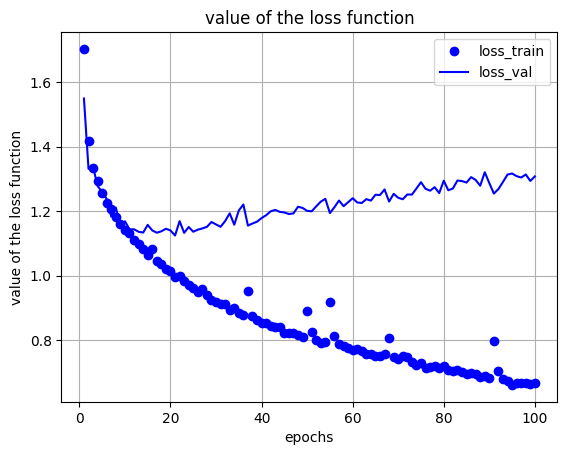

In [ ]:
plot_loss_function(history9b)

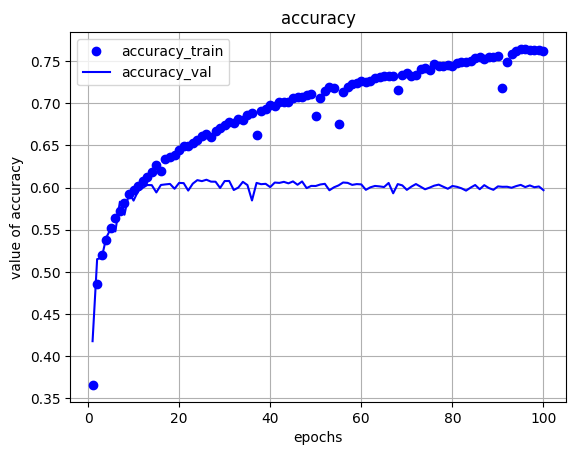

In [ ]:
plot_accuracy(history9b)

In [ ]:
get_best_score(history9b)

0.6093113422393799


## Model 9c - Batch size 256

In [ ]:
model9c = Sequential([
    ##La primera capa convolucional tiene 32 filtros de tamaño (3,3), utiliza la función de activación ReLU,
    ##tiene un relleno ('padding') de 'same' para mantener el tamaño de la imagen y espera una entrada de forma (48, 48, 1).
    Conv2D(32, (3,3), activation = 'relu', padding = 'same', input_shape = (48,48,1)),
    Conv2D(32, (3,3), activation = 'relu', padding = 'same'),

    ##Ambas capas están seguidas por una capa de MaxPooling para reducir la dimensionalidad de la salida.
    MaxPooling2D(2,2),
    ##La capa Dropout se utiliza para regularizar la red y evitar el sobreajuste.
    Dropout(0.25),
    ##La capa BatchNormalization normaliza las activaciones de la capa anterior para mejorar la estabilidad y el entrenamiento.
    BatchNormalization(),

    ##Se repite un patrón similar con dos capas convolucionales adicionales, cada una con 64 filtros y
    ##seguidas por MaxPooling, Dropout y BatchNormalization.
    Conv2D(64, (3,3), activation = 'relu', padding = 'same'),
    Conv2D(64, (3,3), activation = 'relu', padding = 'same'),
    MaxPooling2D(2,2),
    Dropout(0.25),
    BatchNormalization(),

    ##Se repite el patrón nuevamente con dos capas convolucionales más, cada una con 128 filtros.
    Conv2D(128, (3,3), activation = 'relu', padding = 'same'),
    Conv2D(128, (3,3), activation = 'relu', padding = 'same'),
    MaxPooling2D(2,2),
    Dropout(0.25),
    BatchNormalization(),

    ##La capa Flatten se utiliza para transformar la salida
    ##3D de las capas convolucionales en un vector 1D antes de pasar a capas densamente conectadas.
    Flatten(),

    ##Se añaden tres capas densamente conectadas (totalmente conectadas) con funciones de activación ReLU y Dropout para regularización.
    ##La última capa densa tiene 7 neuronas (correspondientes a las clases de salida)
    ## y utiliza la función de activación softmax para la clasificación multiclase.
    Dense(64, activation='relu'),
    Dropout(0.25),
    Dense(32, activation='relu'),
    Dropout(0.25),
    BatchNormalization(),
    Dense(7, activation='softmax')
])

model9c.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 48, 48, 32)        320       
                                                                 
 conv2d_13 (Conv2D)          (None, 48, 48, 32)        9248      
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 24, 24, 32)        0         
 g2D)                                                            
                                                                 
 dropout_10 (Dropout)        (None, 24, 24, 32)        0         
                                                                 
 batch_normalization_8 (Bat  (None, 24, 24, 32)        128       
 chNormalization)                                                
                                                                 
 conv2d_14 (Conv2D)          (None, 24, 24, 64)       

In [ ]:
optimizer = keras.optimizers.Adam(learning_rate=0.001)

model9c.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
%time

early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

history9c = model9c.fit(train_images, train_labels,
                    validation_data=(val_images, val_labels),
                    epochs=100,
                    batch_size=256,
                    callbacks=[early_stopping]
                    )

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.58 µs
Epoch 1/100
300/300 [==============================] - 28s 73ms/step - loss: 1.8398 - accuracy: 0.3190 - val_loss: 1.8310 - val_accuracy: 0.3177
Epoch 2/100
300/300 [==============================] - 19s 63ms/step - loss: 1.5116 - accuracy: 0.4487 - val_loss: 1.7351 - val_accuracy: 0.4242
Epoch 3/100
300/300 [==============================] - 19s 64ms/step - loss: 1.3990 - accuracy: 0.4938 - val_loss: 1.3159 - val_accuracy: 0.5208
Epoch 4/100
300/300 [==============================] - 19s 65ms/step - loss: 1.3335 - accuracy: 0.5188 - val_loss: 1.2582 - val_accuracy: 0.5456
Epoch 5/100
300/300 [==============================] - 19s 65ms/step - loss: 1.2947 - accuracy: 0.5356 - val_loss: 1.2747 - val_accuracy: 0.5377
Epoch 6/100
300/300 [==============================] - 19s 63ms/step - loss: 1.2696 - accuracy: 0.5476 - val_loss: 1.3787 - val_accuracy: 0.5111
Epoch 7/100
300/300 [==============================] - 19s 63ms/st

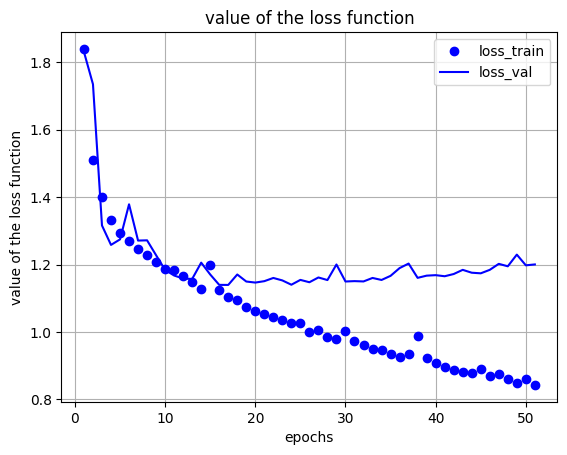

In [ ]:
plot_loss_function(history9c)

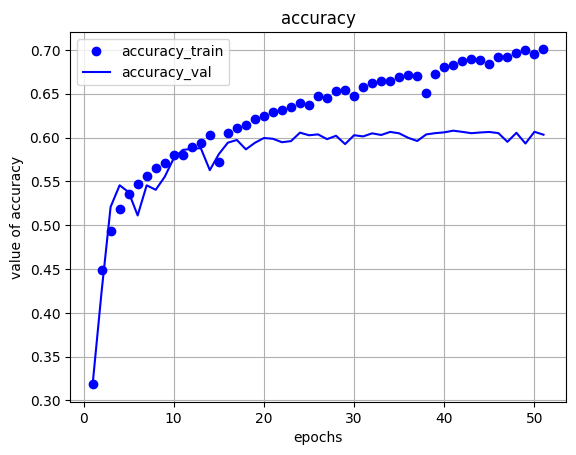

In [ ]:
plot_accuracy(history9c)

In [ ]:
get_best_score(history9c)

0.6078482866287231


## Model 10 - Dropout 0.5

In [ ]:
model10 = Sequential([
    ##La primera capa convolucional tiene 32 filtros de tamaño (3,3), utiliza la función de activación ReLU,
    ##tiene un relleno ('padding') de 'same' para mantener el tamaño de la imagen y espera una entrada de forma (48, 48, 1).
    Conv2D(32, (3,3), activation = 'relu', padding = 'same', input_shape = (48,48,1)),
    Conv2D(32, (3,3), activation = 'relu', padding = 'same'),

    ##Ambas capas están seguidas por una capa de MaxPooling para reducir la dimensionalidad de la salida.
    MaxPooling2D(2,2),
    ##La capa Dropout se utiliza para regularizar la red y evitar el sobreajuste.
    Dropout(0.5),
    ##La capa BatchNormalization normaliza las activaciones de la capa anterior para mejorar la estabilidad y el entrenamiento.
    BatchNormalization(),

    ##Se repite un patrón similar con dos capas convolucionales adicionales, cada una con 64 filtros y
    ##seguidas por MaxPooling, Dropout y BatchNormalization.
    Conv2D(64, (3,3), activation = 'relu', padding = 'same'),
    Conv2D(64, (3,3), activation = 'relu', padding = 'same'),
    MaxPooling2D(2,2),
    Dropout(0.5),
    BatchNormalization(),

    ##Se repite el patrón nuevamente con dos capas convolucionales más, cada una con 128 filtros.
    Conv2D(128, (3,3), activation = 'relu', padding = 'same'),
    Conv2D(128, (3,3), activation = 'relu', padding = 'same'),
    MaxPooling2D(2,2),
    Dropout(0.5),
    BatchNormalization(),

    ##La capa Flatten se utiliza para transformar la salida
    ##3D de las capas convolucionales en un vector 1D antes de pasar a capas densamente conectadas.
    Flatten(),

    ##Se añaden tres capas densamente conectadas (totalmente conectadas) con funciones de activación ReLU y Dropout para regularización.
    ##La última capa densa tiene 7 neuronas (correspondientes a las clases de salida)
    ## y utiliza la función de activación softmax para la clasificación multiclase.
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    BatchNormalization(),
    Dense(7, activation='softmax')
])

model10.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 24, 24, 32)        0         
                                                                 
 batch_normalization (Batch  (None, 24, 24, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 64)        1

In [ ]:
optimizer = keras.optimizers.Adam(learning_rate=0.001)

model10.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
%time

early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

history10 = model10.fit(train_images, train_labels,
                    validation_data=(val_images, val_labels),
                    epochs=100,
                    batch_size=128,
                    callbacks=[early_stopping]
                    )

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.01 µs
Epoch 1/100
599/599 [==============================] - 33s 36ms/step - loss: 1.8754 - accuracy: 0.2743 - val_loss: 2.0291 - val_accuracy: 0.3069
Epoch 2/100
599/599 [==============================] - 19s 32ms/step - loss: 1.6662 - accuracy: 0.3451 - val_loss: 1.6726 - val_accuracy: 0.3466
Epoch 3/100
599/599 [==============================] - 19s 33ms/step - loss: 1.5959 - accuracy: 0.3960 - val_loss: 1.5952 - val_accuracy: 0.4253
Epoch 4/100
599/599 [==============================] - 19s 32ms/step - loss: 1.5253 - accuracy: 0.4377 - val_loss: 1.6397 - val_accuracy: 0.4291
Epoch 5/100
599/599 [==============================] - 19s 32ms/step - loss: 1.4799 - accuracy: 0.4592 - val_loss: 1.4247 - val_accuracy: 0.4887
Epoch 6/100
599/599 [==============================] - 20s 33ms/step - loss: 1.4484 - accuracy: 0.4712 - val_loss: 1.3442 - val_accuracy: 0.5096
Epoch 7/100
599/599 [==============================] - 20s 33ms/st

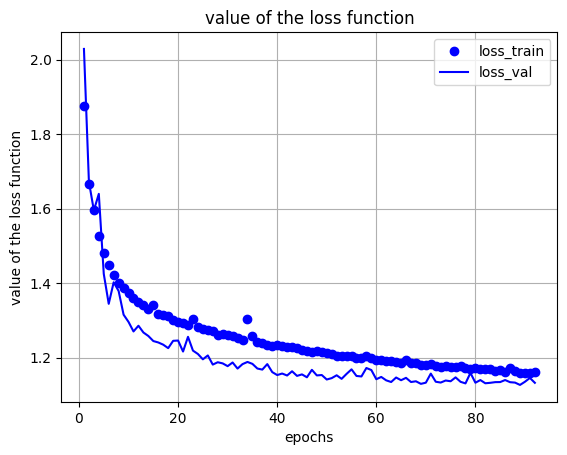

In [ ]:
plot_loss_function(history10)

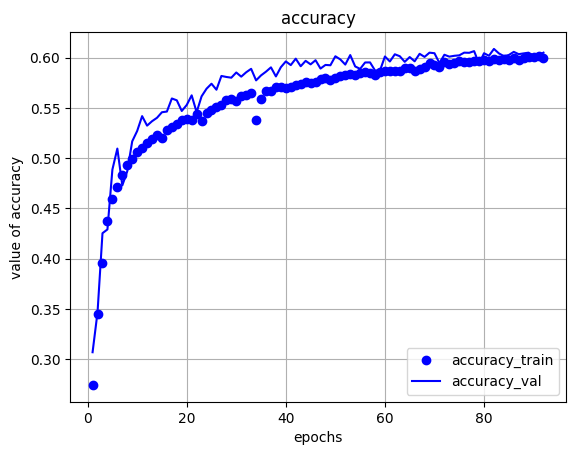

In [ ]:
plot_accuracy(history10)

In [ ]:
get_best_score(history10)

0.6087365746498108


In [ ]:
export_model(model10, "model10")

## Model 11 - Dropout 0.65

In [ ]:
model11 = Sequential([
    ##La primera capa convolucional tiene 32 filtros de tamaño (3,3), utiliza la función de activación ReLU,
    ##tiene un relleno ('padding') de 'same' para mantener el tamaño de la imagen y espera una entrada de forma (48, 48, 1).
    Conv2D(32, (3,3), activation = 'relu', padding = 'same', input_shape = (48,48,1)),
    Conv2D(32, (3,3), activation = 'relu', padding = 'same'),

    ##Ambas capas están seguidas por una capa de MaxPooling para reducir la dimensionalidad de la salida.
    MaxPooling2D(2,2),
    ##La capa Dropout se utiliza para regularizar la red y evitar el sobreajuste.
    Dropout(0.65),
    ##La capa BatchNormalization normaliza las activaciones de la capa anterior para mejorar la estabilidad y el entrenamiento.
    BatchNormalization(),

    ##Se repite un patrón similar con dos capas convolucionales adicionales, cada una con 64 filtros y
    ##seguidas por MaxPooling, Dropout y BatchNormalization.
    Conv2D(64, (3,3), activation = 'relu', padding = 'same'),
    Conv2D(64, (3,3), activation = 'relu', padding = 'same'),
    MaxPooling2D(2,2),
    Dropout(0.65),
    BatchNormalization(),

    ##Se repite el patrón nuevamente con dos capas convolucionales más, cada una con 128 filtros.
    Conv2D(128, (3,3), activation = 'relu', padding = 'same'),
    Conv2D(128, (3,3), activation = 'relu', padding = 'same'),
    MaxPooling2D(2,2),
    Dropout(0.65),
    BatchNormalization(),

    ##La capa Flatten se utiliza para transformar la salida
    ##3D de las capas convolucionales en un vector 1D antes de pasar a capas densamente conectadas.
    Flatten(),

    ##Se añaden tres capas densamente conectadas (totalmente conectadas) con funciones de activación ReLU y Dropout para regularización.
    ##La última capa densa tiene 7 neuronas (correspondientes a las clases de salida)
    ## y utiliza la función de activación softmax para la clasificación multiclase.
    Dense(64, activation='relu'),
    Dropout(0.65),
    Dense(32, activation='relu'),
    Dropout(0.65),
    BatchNormalization(),
    Dense(7, activation='softmax')
])

model11.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 24, 24, 32)        0         
                                                                 
 batch_normalization (Batch  (None, 24, 24, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 64)        1

In [ ]:
optimizer = keras.optimizers.Adam(learning_rate=0.001)

model11.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
%time

early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

history11 = model11.fit(train_images, train_labels,
                    validation_data=(val_images, val_labels),
                    epochs=100,
                    batch_size=128,
                    callbacks=[early_stopping]
                    )

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs
Epoch 1/100
599/599 [==============================] - 35s 39ms/step - loss: 1.9006 - accuracy: 0.2637 - val_loss: 1.7940 - val_accuracy: 0.3067
Epoch 2/100
599/599 [==============================] - 20s 34ms/step - loss: 1.6915 - accuracy: 0.3205 - val_loss: 1.8753 - val_accuracy: 0.3069
Epoch 3/100
599/599 [==============================] - 20s 34ms/step - loss: 1.6552 - accuracy: 0.3365 - val_loss: 1.8963 - val_accuracy: 0.3077
Epoch 4/100
599/599 [==============================] - 21s 35ms/step - loss: 1.6324 - accuracy: 0.3469 - val_loss: 1.8474 - val_accuracy: 0.3115
Epoch 5/100
599/599 [==============================] - 20s 33ms/step - loss: 1.6175 - accuracy: 0.3605 - val_loss: 1.7131 - val_accuracy: 0.3324
Epoch 6/100
599/599 [==============================] - 20s 34ms/step - loss: 1.6013 - accuracy: 0.3775 - val_loss: 1.5662 - val_accuracy: 0.4185
Epoch 7/100
599/599 [==============================] - 20s 33ms/st

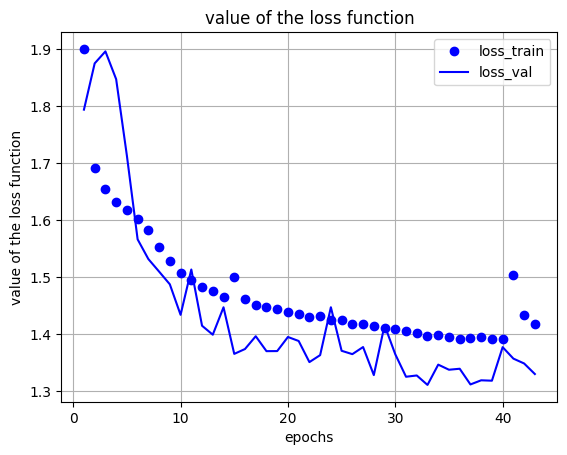

In [ ]:
plot_loss_function(history11)

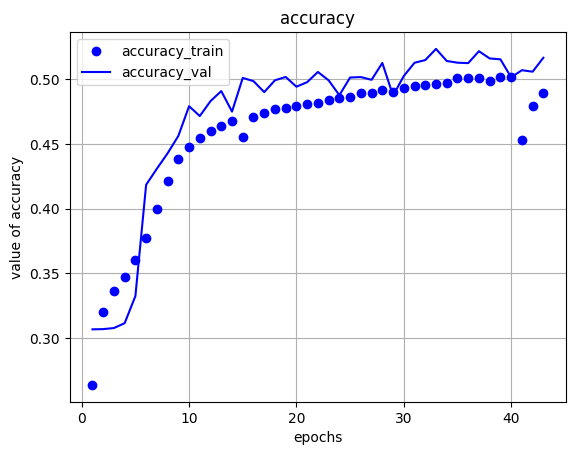

In [ ]:
plot_accuracy(history11)

In [ ]:
get_best_score(history11)

0.5235657095909119


## Model 12 - SGD Optimizer

In [ ]:
model12 = Sequential([
    ##La primera capa convolucional tiene 32 filtros de tamaño (3,3), utiliza la función de activación ReLU,
    ##tiene un relleno ('padding') de 'same' para mantener el tamaño de la imagen y espera una entrada de forma (48, 48, 1).
    Conv2D(32, (3,3), activation = 'relu', padding = 'same', input_shape = (48,48,1)),
    Conv2D(32, (3,3), activation = 'relu', padding = 'same'),

    ##Ambas capas están seguidas por una capa de MaxPooling para reducir la dimensionalidad de la salida.
    MaxPooling2D(2,2),
    ##La capa Dropout se utiliza para regularizar la red y evitar el sobreajuste.
    Dropout(0.5),
    ##La capa BatchNormalization normaliza las activaciones de la capa anterior para mejorar la estabilidad y el entrenamiento.
    BatchNormalization(),

    ##Se repite un patrón similar con dos capas convolucionales adicionales, cada una con 64 filtros y
    ##seguidas por MaxPooling, Dropout y BatchNormalization.
    Conv2D(64, (3,3), activation = 'relu', padding = 'same'),
    Conv2D(64, (3,3), activation = 'relu', padding = 'same'),
    MaxPooling2D(2,2),
    Dropout(0.5),
    BatchNormalization(),

    ##Se repite el patrón nuevamente con dos capas convolucionales más, cada una con 128 filtros.
    Conv2D(128, (3,3), activation = 'relu', padding = 'same'),
    Conv2D(128, (3,3), activation = 'relu', padding = 'same'),
    MaxPooling2D(2,2),
    Dropout(0.5),
    BatchNormalization(),

    ##La capa Flatten se utiliza para transformar la salida
    ##3D de las capas convolucionales en un vector 1D antes de pasar a capas densamente conectadas.
    Flatten(),

    ##Se añaden tres capas densamente conectadas (totalmente conectadas) con funciones de activación ReLU y Dropout para regularización.
    ##La última capa densa tiene 7 neuronas (correspondientes a las clases de salida)
    ## y utiliza la función de activación softmax para la clasificación multiclase.
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    BatchNormalization(),
    Dense(7, activation='softmax')
])

model12.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 48, 48, 32)        320       
                                                                 
 conv2d_13 (Conv2D)          (None, 48, 48, 32)        9248      
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 24, 24, 32)        0         
 g2D)                                                            
                                                                 
 dropout_10 (Dropout)        (None, 24, 24, 32)        0         
                                                                 
 batch_normalization_8 (Bat  (None, 24, 24, 32)        128       
 chNormalization)                                                
                                                                 
 conv2d_14 (Conv2D)          (None, 24, 24, 64)       

In [ ]:
optimizer = keras.optimizers.SGD(learning_rate=0.001)

model12.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
%time

early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

history12 = model12.fit(train_images, train_labels,
                    validation_data=(val_images, val_labels),
                    epochs=100,
                    batch_size=128,
                    callbacks=[early_stopping]
                    )

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.87 µs
Epoch 1/100
599/599 [==============================] - 24s 36ms/step - loss: 2.4173 - accuracy: 0.1583 - val_loss: 1.8827 - val_accuracy: 0.3067
Epoch 2/100
599/599 [==============================] - 21s 34ms/step - loss: 2.2638 - accuracy: 0.1956 - val_loss: 1.8190 - val_accuracy: 0.3069
Epoch 3/100
599/599 [==============================] - 20s 34ms/step - loss: 2.1445 - accuracy: 0.2291 - val_loss: 1.7986 - val_accuracy: 0.3069
Epoch 4/100
599/599 [==============================] - 20s 34ms/step - loss: 2.0559 - accuracy: 0.2574 - val_loss: 1.7894 - val_accuracy: 0.3069
Epoch 5/100
599/599 [==============================] - 21s 35ms/step - loss: 1.9932 - accuracy: 0.2724 - val_loss: 1.7555 - val_accuracy: 0.3081
Epoch 6/100
599/599 [==============================] - 20s 34ms/step - loss: 1.9544 - accuracy: 0.2780 - val_loss: 1.7683 - val_accuracy: 0.3069
Epoch 7/100
599/599 [==============================] - 20s 33ms/st

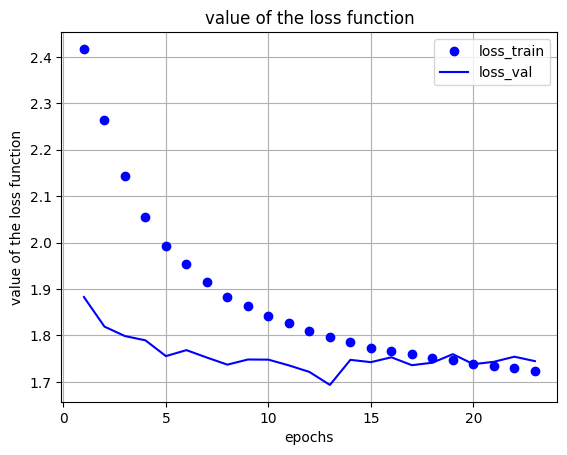

In [ ]:
plot_loss_function(history12)


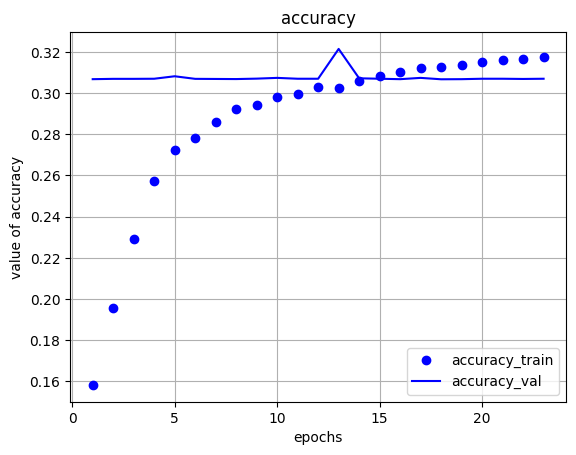

In [ ]:
plot_accuracy(history12)

In [ ]:
get_best_score(history12)

0.3214024305343628


## Model 13 - Adamax optimizer

In [ ]:
model13 = Sequential([
    ##La primera capa convolucional tiene 32 filtros de tamaño (3,3), utiliza la función de activación ReLU,
    ##tiene un relleno ('padding') de 'same' para mantener el tamaño de la imagen y espera una entrada de forma (48, 48, 1).
    Conv2D(32, (3,3), activation = 'relu', padding = 'same', input_shape = (48,48,1)),
    Conv2D(32, (3,3), activation = 'relu', padding = 'same'),

    ##Ambas capas están seguidas por una capa de MaxPooling para reducir la dimensionalidad de la salida.
    MaxPooling2D(2,2),
    ##La capa Dropout se utiliza para regularizar la red y evitar el sobreajuste.
    Dropout(0.5),
    ##La capa BatchNormalization normaliza las activaciones de la capa anterior para mejorar la estabilidad y el entrenamiento.
    BatchNormalization(),

    ##Se repite un patrón similar con dos capas convolucionales adicionales, cada una con 64 filtros y
    ##seguidas por MaxPooling, Dropout y BatchNormalization.
    Conv2D(64, (3,3), activation = 'relu', padding = 'same'),
    Conv2D(64, (3,3), activation = 'relu', padding = 'same'),
    MaxPooling2D(2,2),
    Dropout(0.5),
    BatchNormalization(),

    ##Se repite el patrón nuevamente con dos capas convolucionales más, cada una con 128 filtros.
    Conv2D(128, (3,3), activation = 'relu', padding = 'same'),
    Conv2D(128, (3,3), activation = 'relu', padding = 'same'),
    MaxPooling2D(2,2),
    Dropout(0.5),
    BatchNormalization(),

    ##La capa Flatten se utiliza para transformar la salida
    ##3D de las capas convolucionales en un vector 1D antes de pasar a capas densamente conectadas.
    Flatten(),

    ##Se añaden tres capas densamente conectadas (totalmente conectadas) con funciones de activación ReLU y Dropout para regularización.
    ##La última capa densa tiene 7 neuronas (correspondientes a las clases de salida)
    ## y utiliza la función de activación softmax para la clasificación multiclase.
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    BatchNormalization(),
    Dense(7, activation='softmax')
])

model13.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 48, 48, 32)        320       
                                                                 
 conv2d_19 (Conv2D)          (None, 48, 48, 32)        9248      
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 24, 24, 32)        0         
 g2D)                                                            
                                                                 
 dropout_15 (Dropout)        (None, 24, 24, 32)        0         
                                                                 
 batch_normalization_12 (Ba  (None, 24, 24, 32)        128       
 tchNormalization)                                               
                                                                 
 conv2d_20 (Conv2D)          (None, 24, 24, 64)       

In [ ]:
optimizer = keras.optimizers.Adamax(learning_rate=0.001)

model13.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
%time

early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

history13 = model13.fit(train_images, train_labels,
                    validation_data=(val_images, val_labels),
                    epochs=100,
                    batch_size=128,
                    callbacks=[early_stopping]
                    )

CPU times: user 0 ns, sys: 4 µs, total: 4 µs
Wall time: 7.63 µs
Epoch 1/100
599/599 [==============================] - 25s 36ms/step - loss: 2.0035 - accuracy: 0.2527 - val_loss: 1.8117 - val_accuracy: 0.3067
Epoch 2/100
599/599 [==============================] - 21s 35ms/step - loss: 1.7543 - accuracy: 0.3136 - val_loss: 1.7672 - val_accuracy: 0.3081
Epoch 3/100
599/599 [==============================] - 20s 34ms/step - loss: 1.6925 - accuracy: 0.3310 - val_loss: 1.7633 - val_accuracy: 0.3084
Epoch 4/100
599/599 [==============================] - 21s 34ms/step - loss: 1.6532 - accuracy: 0.3554 - val_loss: 1.7086 - val_accuracy: 0.3305
Epoch 5/100
599/599 [==============================] - 20s 34ms/step - loss: 1.6226 - accuracy: 0.3769 - val_loss: 1.6566 - val_accuracy: 0.3688
Epoch 6/100
599/599 [==============================] - 20s 34ms/step - loss: 1.5950 - accuracy: 0.3979 - val_loss: 1.5960 - val_accuracy: 0.4138
Epoch 7/100
599/599 [==============================] - 20s 34ms/st

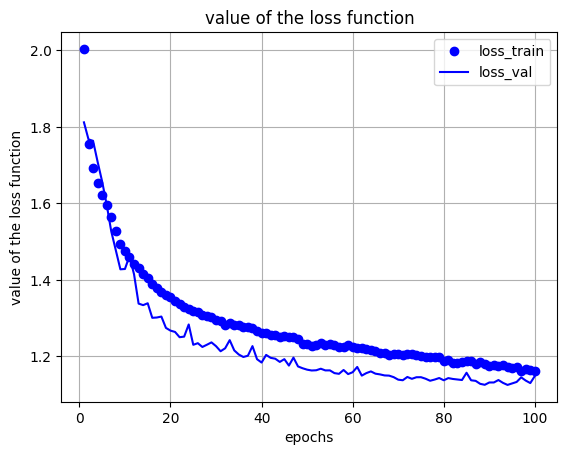

In [ ]:
plot_loss_function(history13)

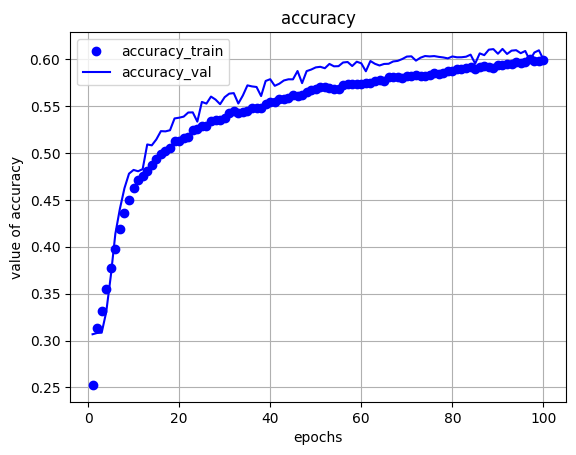

In [ ]:
plot_accuracy(history13)

In [ ]:
get_best_score(history13)

0.6110356450080872


In [ ]:
export_model(model13, "model13")

## Model 14 - Nadam optimizer

In [ ]:
model14 = Sequential([
    ##La primera capa convolucional tiene 32 filtros de tamaño (3,3), utiliza la función de activación ReLU,
    ##tiene un relleno ('padding') de 'same' para mantener el tamaño de la imagen y espera una entrada de forma (48, 48, 1).
    Conv2D(32, (3,3), activation = 'relu', padding = 'same', input_shape = (48,48,1)),
    Conv2D(32, (3,3), activation = 'relu', padding = 'same'),

    ##Ambas capas están seguidas por una capa de MaxPooling para reducir la dimensionalidad de la salida.
    MaxPooling2D(2,2),
    ##La capa Dropout se utiliza para regularizar la red y evitar el sobreajuste.
    Dropout(0.5),
    ##La capa BatchNormalization normaliza las activaciones de la capa anterior para mejorar la estabilidad y el entrenamiento.
    BatchNormalization(),

    ##Se repite un patrón similar con dos capas convolucionales adicionales, cada una con 64 filtros y
    ##seguidas por MaxPooling, Dropout y BatchNormalization.
    Conv2D(64, (3,3), activation = 'relu', padding = 'same'),
    Conv2D(64, (3,3), activation = 'relu', padding = 'same'),
    MaxPooling2D(2,2),
    Dropout(0.5),
    BatchNormalization(),

    ##Se repite el patrón nuevamente con dos capas convolucionales más, cada una con 128 filtros.
    Conv2D(128, (3,3), activation = 'relu', padding = 'same'),
    Conv2D(128, (3,3), activation = 'relu', padding = 'same'),
    MaxPooling2D(2,2),
    Dropout(0.5),
    BatchNormalization(),

    ##La capa Flatten se utiliza para transformar la salida
    ##3D de las capas convolucionales en un vector 1D antes de pasar a capas densamente conectadas.
    Flatten(),

    ##Se añaden tres capas densamente conectadas (totalmente conectadas) con funciones de activación ReLU y Dropout para regularización.
    ##La última capa densa tiene 7 neuronas (correspondientes a las clases de salida)
    ## y utiliza la función de activación softmax para la clasificación multiclase.
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    BatchNormalization(),
    Dense(7, activation='softmax')
])

model14.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 24, 24, 32)        0         
                                                                 
 batch_normalization (Batch  (None, 24, 24, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 64)        1

In [ ]:
optimizer = keras.optimizers.Nadam(learning_rate=0.001)

model14.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
%time

early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

history14 = model14.fit(train_images, train_labels,
                    validation_data=(val_images, val_labels),
                    epochs=100,
                    batch_size=128,
                    callbacks=[early_stopping]
                    )

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 6.91 µs
Epoch 1/100
599/599 [==============================] - 38s 41ms/step - loss: 1.8969 - accuracy: 0.2640 - val_loss: 1.8782 - val_accuracy: 0.3068
Epoch 2/100
599/599 [==============================] - 23s 38ms/step - loss: 1.6671 - accuracy: 0.3407 - val_loss: 1.6683 - val_accuracy: 0.3305
Epoch 3/100
599/599 [==============================] - 22s 37ms/step - loss: 1.5897 - accuracy: 0.3999 - val_loss: 1.5405 - val_accuracy: 0.4384
Epoch 4/100
599/599 [==============================] - 22s 36ms/step - loss: 1.5300 - accuracy: 0.4338 - val_loss: 1.4529 - val_accuracy: 0.4668
Epoch 5/100
599/599 [==============================] - 21s 36ms/step - loss: 1.4798 - accuracy: 0.4591 - val_loss: 1.3812 - val_accuracy: 0.4912
Epoch 6/100
599/599 [==============================] - 21s 36ms/step - loss: 1.4448 - accuracy: 0.4744 - val_loss: 1.3668 - val_accuracy: 0.4999
Epoch 7/100
599/599 [==============================] - 22s 36m

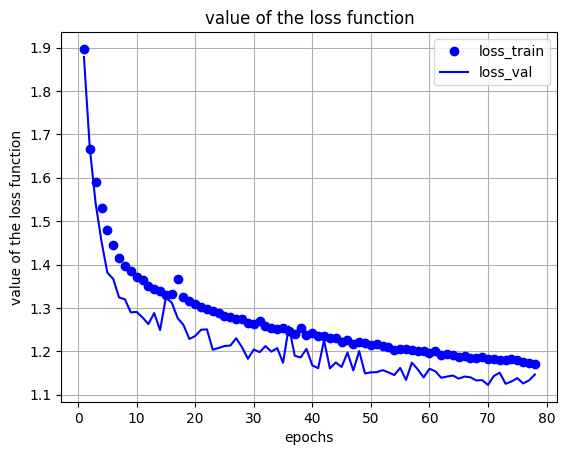

In [ ]:
plot_loss_function(history14)

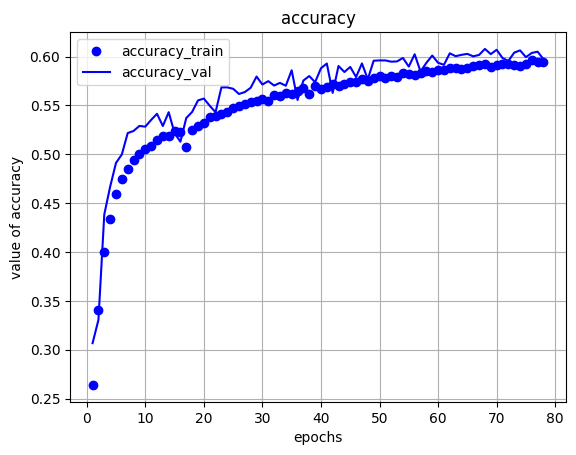

In [ ]:
plot_accuracy(history14)

In [ ]:
get_best_score(history14)

0.6077960133552551


In [ ]:
export_model(model14, "model14")

## Model 15 - Hyperas
https://github.com/maxpumperla/hyperas

### Functions

In [ ]:
def data_hyperas():
    """
    Data providing function:

    This function is separated from create_model_hyperas() so that hyperopt
    won't reload data for each evaluation run.
    """
    return train_images, train_labels, val_images, val_labels

In [ ]:
def create_model_hyperas(x_train, y_train, x_test, y_test):
    """
    Model providing function:

    Create Keras model with double curly brackets dropped-in as needed.
    Return value has to be a valid python dictionary with two customary keys:
        - loss: Specify a numeric evaluation metric to be minimized
        - status: Just use STATUS_OK and see hyperopt documentation if not feasible
    The last one is optional, though recommended, namely:
        - model: specify the model just created so that we can later use it again.
    """
    model = Sequential([
    ##La primera capa convolucional tiene 32 filtros de tamaño (3,3), utiliza la función de activación ReLU,
    ##tiene un relleno ('padding') de 'same' para mantener el tamaño de la imagen y espera una entrada de forma (48, 48, 1).
    Conv2D(32, (3,3), activation = 'relu', padding = 'same', input_shape = (48,48,1)),
    Conv2D(32, (3,3), activation = 'relu', padding = 'same'),

    ##Ambas capas están seguidas por una capa de MaxPooling para reducir la dimensionalidad de la salida.
    MaxPooling2D(2,2),
    ##La capa Dropout se utiliza para regularizar la red y evitar el sobreajuste.
    Dropout({{uniform(0, 1)}}),
    ##La capa BatchNormalization normaliza las activaciones de la capa anterior para mejorar la estabilidad y el entrenamiento.
    BatchNormalization(),

    ##Se repite un patrón similar con dos capas convolucionales adicionales, cada una con 64 filtros y
    ##seguidas por MaxPooling, Dropout y BatchNormalization.
    Conv2D(64, (3,3), activation = 'relu', padding = 'same'),
    Conv2D(64, (3,3), activation = 'relu', padding = 'same'),
    MaxPooling2D(2,2),
    Dropout({{uniform(0, 1)}}),
    BatchNormalization(),

    ##Se repite el patrón nuevamente con dos capas convolucionales más, cada una con 128 filtros.
    Conv2D(128, (3,3), activation = 'relu', padding = 'same'),
    Conv2D(128, (3,3), activation = 'relu', padding = 'same'),
    MaxPooling2D(2,2),
    Dropout({{uniform(0, 1)}}),
    BatchNormalization(),

    ##La capa Flatten se utiliza para transformar la salida
    ##3D de las capas convolucionales en un vector 1D antes de pasar a capas densamente conectadas.
    Flatten(),

    ##Se añaden tres capas densamente conectadas (totalmente conectadas) con funciones de activación ReLU y Dropout para regularización.
    ##La última capa densa tiene 7 neuronas (correspondientes a las clases de salida)
    ## y utiliza la función de activación softmax para la clasificación multiclase.
    Dense(64, activation='relu'),
    Dropout({{uniform(0, 1)}}),
    Dense(32, activation='relu'),
    Dropout({{uniform(0, 1)}}),
    BatchNormalization(),
    Dense(7, activation='softmax')
])

    model.compile(loss='categorical_crossentropy', metrics=['accuracy'],
                  optimizer={{choice(['rmsprop', 'adam', 'sgd','nadam', 'adamax'])}})

    result = model.fit(x_train, y_train,
              batch_size={{choice([64, 128, 256])}},
              epochs=50,
              verbose=2,
              validation_split=0.1)
    #get the highest validation accuracy of the training epochs
    validation_acc = np.amax(result.history['val_accuracy'])
    print('Best validation acc of epoch:', validation_acc)
    return {'loss': -validation_acc, 'status': STATUS_OK, 'model': model}

### Run

In [ ]:
best_run, best_model = optim.minimize(model=create_model_hyperas,
                                          data=data_hyperas,
                                          algo=tpe.suggest,
                                          max_evals=5,
                                          trials=Trials(),
                                          notebook_name=NOTEBOOKS_PATH+'hyperas_notebook',
                                          )

X_train, Y_train, X_test, Y_test = data_hyperas()
print("Evalutation of best performing model:")
print(best_model.evaluate(X_test, Y_test))
print("Best performing model chosen hyper-parameters:")
print(best_run)

>>> Imports:
#coding=utf-8

>>> Hyperas search space:

def get_space():
    return {
        'Dropout': hp.uniform('Dropout', 0, 1),
        'Dropout_1': hp.uniform('Dropout_1', 0, 1),
        'Dropout_2': hp.uniform('Dropout_2', 0, 1),
        'Dropout_3': hp.uniform('Dropout_3', 0, 1),
        'Dropout_4': hp.uniform('Dropout_4', 0, 1),
        'optimizer': hp.choice('optimizer', ['rmsprop', 'adam', 'sgd','nadam', 'adamax']),
        'batch_size': hp.choice('batch_size', [64, 128, 256]),
    }

>>> Data
  1: 
  2: """
  3: Data providing function:
  4: 
  5: This function is separated from create_model_hyperas() so that hyperopt
  6: won't reload data for each evaluation run.
  7: """
  8: 
  9: 
 10: 
>>> Resulting replaced keras model:

   1: def keras_fmin_fnct(space):
   2: 
   3:     """
   4:     Model providing function:
   5: 
   6:     Create Keras model with double curly brackets dropped-in as needed.
   7:     Return value has to be a valid python dictionary with two custo

AttributeError: 'numpy.random.mtrand.RandomState' object has no attribute 'integers'

## Model 16 - Transfer Learning - VGG16

In [ ]:
train_images.shape

(76550, 48, 48, 1)

In [ ]:
X_train_rgb = np.repeat(train_images, 3, axis=-1)

# Preprocesar las imágenes para que coincidan con la entrada de VGG16
X_train_preprocessed = preprocess_input(X_train_rgb)

In [ ]:
X_val_rgb = np.repeat(val_images, 3, axis=-1)

# Preprocesar las imágenes para que coincidan con la entrada de VGG16
X_val_preprocessed = preprocess_input(X_val_rgb)

In [ ]:
X_train_preprocessed.shape

(76550, 48, 48, 3)

In [ ]:
X_val_preprocessed.shape

(19138, 48, 48, 3)

In [ ]:
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(48,48,3))

58889256/58889256 [==============================] - 2s 0us/step


In [ ]:
base_model.trainable=False

In [ ]:
model16 = Sequential([
    base_model,
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    BatchNormalization(),
    Dense(7, activation='softmax')
])

model16.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 64)                32832     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 batch_normalization (Batch  (None, 32)                1

In [ ]:
optimizer = keras.optimizers.Adamax(learning_rate=0.001)

model16.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
%time

early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

history16 = model16.fit(X_train_preprocessed, train_labels,
                    validation_data=(X_val_preprocessed, val_labels),
                    epochs=100,
                    batch_size=128,
                    callbacks=[early_stopping]
                    )

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 6.68 µs


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/100
599/599 [==============================] - 104s 153ms/step - loss: 2.0551 - accuracy: 0.2268 - val_loss: 1.7473 - val_accuracy: 0.3069
Epoch 2/100
599/599 [==============================] - 86s 144ms/step - loss: 1.8087 - accuracy: 0.2850 - val_loss: 1.7366 - val_accuracy: 0.3069
Epoch 3/100
599/599 [==============================] - 86s 144ms/step - loss: 1.7626 - accuracy: 0.2935 - val_loss: 1.7367 - val_accuracy: 0.3069
Epoch 4/100
599/599 [==============================] - 86s 144ms/step - loss: 1.7487 - accuracy: 0.3029 - val_loss: 1.7364 - val_accuracy: 0.3069
Epoch 5/100
599/599 [==============================] - 86s 144ms/step - loss: 1.7439 - accuracy: 0.3049 - val_loss: 1.7364 - val_accuracy: 0.3069
Epoch 6/100
496/599 [=======================>......] - ETA: 13s - loss: 1.7408 - accuracy: 0.3062

KeyboardInterrupt: 

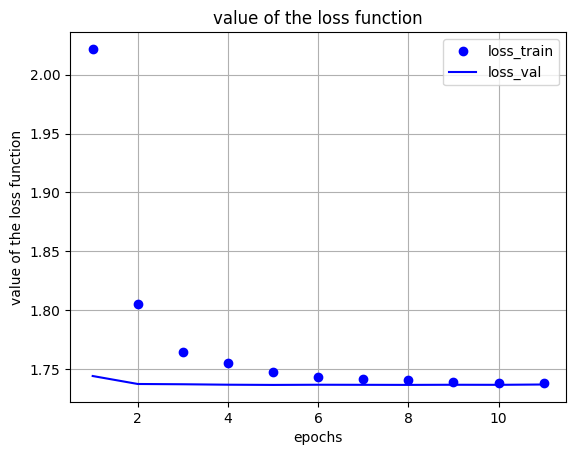

In [ ]:
plot_loss_function(history16)

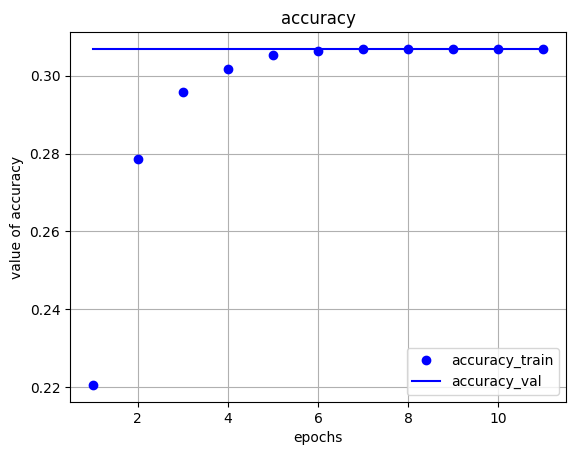

In [ ]:
plot_accuracy(history16)

In [ ]:
get_best_score(history16)

0.30687636137008667


## Model 17 - Transfer Learning - ResNet

In [ ]:
X_train_rgb = np.repeat(train_images, 3, axis=-1)

# Preprocesar las imágenes para que coincidan con la entrada de VGG16
X_train_preprocessed = preprocess_input(X_train_rgb)

In [ ]:
X_val_rgb = np.repeat(val_images, 3, axis=-1)

# Preprocesar las imágenes para que coincidan con la entrada de VGG16
X_val_preprocessed = preprocess_input(X_val_rgb)

In [ ]:
base_model = ResNet152V2(input_shape=(48,48,3), include_top=False, weights="imagenet")

234545216/234545216 [==============================] - 7s 0us/step


In [ ]:
base_model.trainable=False

In [ ]:
model17 = Sequential([
    base_model,
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(7, activation='softmax')
])

model17.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152v2 (Functional)    (None, 2, 2, 2048)        58331648  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 64)                524352    
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 7)                 2

In [ ]:
optimizer = keras.optimizers.Adamax(learning_rate=0.001)

model17.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
%time

early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

history17 = model17.fit(X_train_preprocessed, train_labels,
                    validation_data=(X_val_preprocessed, val_labels),
                    epochs=100,
                    batch_size=128,
                    callbacks=[early_stopping]
                    )

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.48 µs


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/100
599/599 [==============================] - 399s 653ms/step - loss: 30.2174 - accuracy: 0.2787 - val_loss: 1.7899 - val_accuracy: 0.3069
Epoch 2/100
599/599 [==============================] - 421s 703ms/step - loss: 1.7681 - accuracy: 0.2904 - val_loss: 1.7474 - val_accuracy: 0.3069
Epoch 3/100
599/599 [==============================] - 384s 642ms/step - loss: 1.7464 - accuracy: 0.3002 - val_loss: 1.7389 - val_accuracy: 0.3069
Epoch 4/100
599/599 [==============================] - 384s 642ms/step - loss: 1.7421 - accuracy: 0.3069 - val_loss: 1.7375 - val_accuracy: 0.3069
Epoch 5/100
599/599 [==============================] - 386s 644ms/step - loss: 1.7403 - accuracy: 0.3069 - val_loss: 1.7370 - val_accuracy: 0.3069
Epoch 6/100
599/599 [==============================] - 385s 643ms/step - loss: 1.7393 - accuracy: 0.3069 - val_loss: 1.7368 - val_accuracy: 0.3069
Epoch 7/100
599/599 [==============================] - 421s 704ms/step - loss: 1.7385 - accuracy: 0.3069 - val_loss: 

KeyboardInterrupt: 

## Model 18 - Using dataset splitted in 3

In [ ]:
model18 = Sequential([
    ##La primera capa convolucional tiene 32 filtros de tamaño (3,3), utiliza la función de activación ReLU,
    ##tiene un relleno ('padding') de 'same' para mantener el tamaño de la imagen y espera una entrada de forma (48, 48, 1).
    Conv2D(32, (3,3), activation = 'relu', padding = 'same', input_shape = (48,48,1)),
    Conv2D(32, (3,3), activation = 'relu', padding = 'same'),

    ##Ambas capas están seguidas por una capa de MaxPooling para reducir la dimensionalidad de la salida.
    MaxPooling2D(2,2),
    ##La capa Dropout se utiliza para regularizar la red y evitar el sobreajuste.
    Dropout(0.5),
    ##La capa BatchNormalization normaliza las activaciones de la capa anterior para mejorar la estabilidad y el entrenamiento.
    BatchNormalization(),

    ##Se repite un patrón similar con dos capas convolucionales adicionales, cada una con 64 filtros y
    ##seguidas por MaxPooling, Dropout y BatchNormalization.
    Conv2D(64, (3,3), activation = 'relu', padding = 'same'),
    Conv2D(64, (3,3), activation = 'relu', padding = 'same'),
    MaxPooling2D(2,2),
    Dropout(0.5),
    BatchNormalization(),

    ##Se repite el patrón nuevamente con dos capas convolucionales más, cada una con 128 filtros.
    Conv2D(128, (3,3), activation = 'relu', padding = 'same'),
    Conv2D(128, (3,3), activation = 'relu', padding = 'same'),
    MaxPooling2D(2,2),
    Dropout(0.5),
    BatchNormalization(),

    ##La capa Flatten se utiliza para transformar la salida
    ##3D de las capas convolucionales en un vector 1D antes de pasar a capas densamente conectadas.
    Flatten(),

    ##Se añaden tres capas densamente conectadas (totalmente conectadas) con funciones de activación ReLU y Dropout para regularización.
    ##La última capa densa tiene 7 neuronas (correspondientes a las clases de salida)
    ## y utiliza la función de activación softmax para la clasificación multiclase.
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    BatchNormalization(),
    Dense(7, activation='softmax')
])

model18.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 24, 24, 32)        0         
                                                                 
 batch_normalization (Batch  (None, 24, 24, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 64)        1

In [ ]:
optimizer = keras.optimizers.Adamax(learning_rate=0.001)

model18.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
%time

early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

history18 = model18.fit(train_images_in_3, train_labels_in_3,
                    validation_data=(val_images_in_3, val_labels_in_3),
                    epochs=200,
                    batch_size=128,
                    callbacks=[early_stopping]
                    )

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 6.91 µs


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/200
449/449 [==============================] - 68s 136ms/step - loss: 2.0880 - accuracy: 0.2359 - val_loss: 1.8945 - val_accuracy: 0.3075
Epoch 2/200
449/449 [==============================] - 58s 130ms/step - loss: 1.8097 - accuracy: 0.2950 - val_loss: 1.8172 - val_accuracy: 0.3083
Epoch 3/200
449/449 [==============================] - 58s 129ms/step - loss: 1.7244 - accuracy: 0.3234 - val_loss: 1.8138 - val_accuracy: 0.3089
Epoch 4/200
449/449 [==============================] - 57s 127ms/step - loss: 1.6767 - accuracy: 0.3418 - val_loss: 1.6187 - val_accuracy: 0.3923
Epoch 5/200
449/449 [==============================] - 57s 126ms/step - loss: 1.6302 - accuracy: 0.3766 - val_loss: 1.6842 - val_accuracy: 0.3580
Epoch 6/200
449/449 [==============================] - 56s 125ms/step - loss: 1.5948 - accuracy: 0.4033 - val_loss: 1.6143 - val_accuracy: 0.4024
Epoch 7/200
449/449 [==============================] - 57s 127ms/step - loss: 1.5583 - accuracy: 0.4256 - val_loss: 1.4940 -

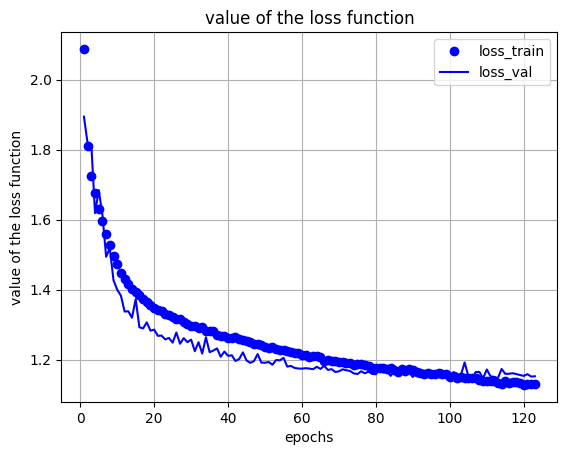

In [ ]:
plot_loss_function(history18)

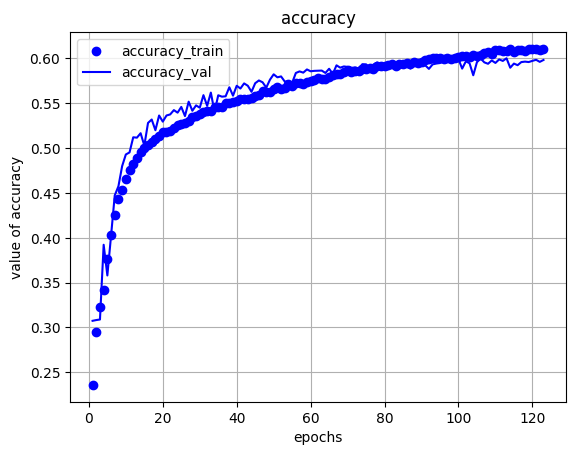

In [ ]:
plot_accuracy(history18)

In [ ]:
get_best_score(history18)

0.6002717018127441


In [ ]:
export_model(model18, "model18")

In [ ]:
model18.evaluate(test_images_in_3, test_labels_in_3)

599/599 [==============================] - 17s 27ms/step - loss: 1.1364 - accuracy: 0.6040


[1.13640558719635, 0.604033887386322]

## Model 19 - Best Model using Data Augmentation

In [ ]:
model19 = Sequential([
    ##La primera capa convolucional tiene 32 filtros de tamaño (3,3), utiliza la función de activación ReLU,
    ##tiene un relleno ('padding') de 'same' para mantener el tamaño de la imagen y espera una entrada de forma (48, 48, 1).
    Conv2D(32, (3,3), activation = 'relu', padding = 'same', input_shape = (48,48,1)),
    Conv2D(32, (3,3), activation = 'relu', padding = 'same'),

    ##Ambas capas están seguidas por una capa de MaxPooling para reducir la dimensionalidad de la salida.
    MaxPooling2D(2,2),
    ##La capa Dropout se utiliza para regularizar la red y evitar el sobreajuste.
    Dropout(0.5),
    ##La capa BatchNormalization normaliza las activaciones de la capa anterior para mejorar la estabilidad y el entrenamiento.
    BatchNormalization(),

    ##Se repite un patrón similar con dos capas convolucionales adicionales, cada una con 64 filtros y
    ##seguidas por MaxPooling, Dropout y BatchNormalization.
    Conv2D(64, (3,3), activation = 'relu', padding = 'same'),
    Conv2D(64, (3,3), activation = 'relu', padding = 'same'),
    MaxPooling2D(2,2),
    Dropout(0.5),
    BatchNormalization(),

    ##Se repite el patrón nuevamente con dos capas convolucionales más, cada una con 128 filtros.
    Conv2D(128, (3,3), activation = 'relu', padding = 'same'),
    Conv2D(128, (3,3), activation = 'relu', padding = 'same'),
    MaxPooling2D(2,2),
    Dropout(0.5),
    BatchNormalization(),

    ##La capa Flatten se utiliza para transformar la salida
    ##3D de las capas convolucionales en un vector 1D antes de pasar a capas densamente conectadas.
    Flatten(),

    ##Se añaden tres capas densamente conectadas (totalmente conectadas) con funciones de activación ReLU y Dropout para regularización.
    ##La última capa densa tiene 7 neuronas (correspondientes a las clases de salida)
    ## y utiliza la función de activación softmax para la clasificación multiclase.
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    BatchNormalization(),
    Dense(7, activation='softmax')
])

model19.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 24, 24, 32)        0         
                                                                 
 batch_normalization (Batch  (None, 24, 24, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 64)        1

In [ ]:
optimizer = keras.optimizers.Adamax(learning_rate=0.001)

model19.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
%time

early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

history19 = model19.fit(train_generator,
                    steps_per_epoch=step_size_train,
                    validation_data=(val_images, val_labels),
                    epochs=200,
                    batch_size=128,
                    callbacks=[early_stopping]
                    )

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 8.58 µs
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


2392/2392 [==============================] - 320s 130ms/step - loss: 1.8915 - accuracy: 0.2687 - val_loss: 1.7823 - val_accuracy: 0.3068
Epoch 2/200
2392/2392 [==============================] - 307s 128ms/step - loss: 1.7198 - accuracy: 0.3080 - val_loss: 1.7480 - val_accuracy: 0.3071
Epoch 3/200
2392/2392 [==============================] - 314s 131ms/step - loss: 1.6980 - accuracy: 0.3178 - val_loss: 1.7453 - val_accuracy: 0.3092
Epoch 4/200
2392/2392 [==============================] - 317s 133ms/step - loss: 1.6866 - accuracy: 0.3208 - val_loss: 1.6571 - val_accuracy: 0.3320
Epoch 5/200
2392/2392 [==============================] - 315s 132ms/step - loss: 1.6742 - accuracy: 0.3276 - val_loss: 1.6669 - val_accuracy: 0.3307
Epoch 6/200
2392/2392 [==============================] - 317s 133ms/step - loss: 1.6675 - accuracy: 0.3323 - val_loss: 1.6297 - val_accuracy: 0.3511
Epoch 7/200
2392/2392 [==============================] - 306s 128ms/step - loss: 1.6596 - accuracy: 0.3361 - val_loss:

In [ ]:
plot_loss_function(history19)

In [ ]:
plot_accuracy(history19)

In [ ]:
get_best_score(history19)

In [ ]:
export_model(model19, "model19")

# Import Model

In [ ]:
model_name = "model18"
with open(MODELS_PATH + model_name + '.json','r') as f:
    json = f.read()
model_imported = model_from_json(json)

model_imported.load_weights(MODELS_PATH + model_name + '.h5')
print("Loaded model from disk")

Loaded model from disk


/content/drive/MyDrive/TPP/TPP - sisop?/Datasets/EmoReact/Frames/emotionless_iPOD20_2.mp40017.jpg


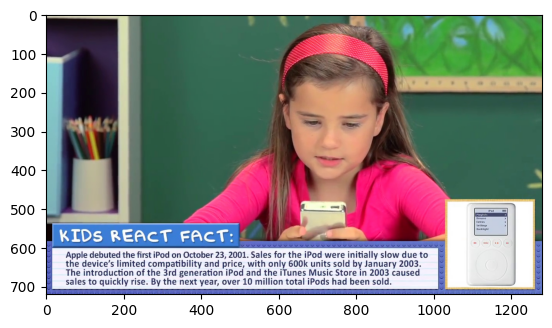

In [ ]:
# image_name = "afraid_asian_7.jpg"
image_name = "emotionless_iPOD20_2.mp40017.jpg"

test_path = DATASETS_PATH + EMO_REACT_PATH + image_name

print(test_path)

print_image(test_path)

In [ ]:
face, face_pixels = detect_and_process_face(test_path)

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 [==============================] - 0s 242ms/step


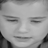

In [ ]:
face

In [ ]:
res = model_imported.predict(face_pixels)
result_num = np.argmax(res)

get_emotion(result_num)

1/1 [==============================] - 1s 503ms/step


'Neutral'

/content/drive/MyDrive/TPP/TPP - sisop?/Datasets/Examples/disgusted.jpg


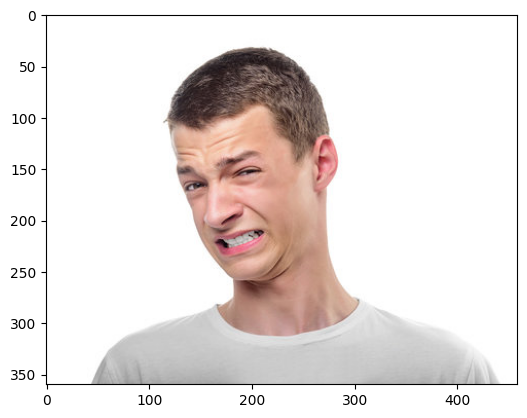

In [ ]:
# image_name = "afraid_asian_7.jpg"
image_name = "disgusted.jpg"

test_path = DATASETS_PATH + EXAMPLES_PATH + image_name

print(test_path)

print_image(test_path)

In [ ]:
face, face_pixels = detect_and_process_face(test_path)

1/1 [==============================] - 0s 181ms/step


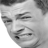

In [ ]:
face

In [ ]:
res = model_imported.predict(face_pixels)
result_num = np.argmax(res)

get_emotion(result_num)

1/1 [==============================] - 0s 45ms/step


'Sad'

/content/drive/MyDrive/TPP/TPP - sisop?/Datasets/Examples/fear.jpg


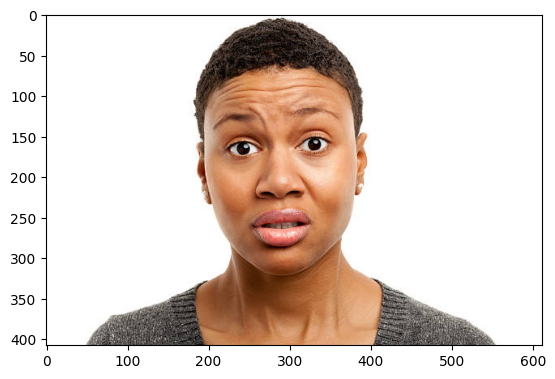

In [ ]:
# image_name = "afraid_asian_7.jpg"
image_name = "fear.jpg"

test_path = DATASETS_PATH + EXAMPLES_PATH + image_name

print(test_path)

print_image(test_path)

In [ ]:
face, face_pixels = detect_and_process_face(test_path)

1/1 [==============================] - 0s 172ms/step


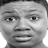

In [ ]:
face

In [ ]:
res = model_imported.predict(face_pixels)
result_num = np.argmax(res)

get_emotion(result_num)

1/1 [==============================] - 0s 30ms/step


'Surprise'

/content/drive/MyDrive/TPP/TPP - sisop?/Datasets/Examples/Nico_contento.jpg


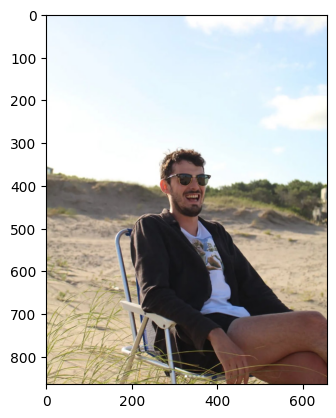

In [ ]:
image_name = "Nico_contento.jpg"

test_path = DATASETS_PATH + EXAMPLES_PATH + image_name

print(test_path)

print_image(test_path)

In [ ]:
face, face_pixels = detect_and_process_face(test_path)

1/1 [==============================] - 0s 184ms/step


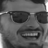

In [ ]:
face

In [ ]:
res = model_imported.predict(face_pixels)
result_num = np.argmax(res)

get_emotion(result_num)

1/1 [==============================] - 0s 80ms/step


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


'Happy'